In [2]:
# packages
import os
import gc
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_curve, auc, f1_score, mean_squared_error, accuracy_score, mean_squared_error,log_loss
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchinfo import summary
from torch.utils.data import DataLoader, Dataset

In [3]:
torch.__version__

'2.0.1'

In [4]:
EPOCHS = 2000
LR = 1e-3
BS = 32
SEED = 42
MODEL_NAME ='model'
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
seed_everything(SEED) # Seed 고정

In [5]:
device = torch.device('cpu') if torch.backends.mps.is_available() else torch.device('cpu')
print(device)

cpu


In [6]:
df = pd.read_csv('./raw_data.csv')
df

,EQUIP_ID,MFG_DT,SALE_CD,MOLD_POS,REAL_POWER,CP,AX,MOLD_IN_TOP,MOLD_IN_BOT,MOLD_OUT_TOP,MOLD_OUT_BOT,IN_RADIUS,OUT_RADIUS,POWER,POWER1,POWER2,POWER3,POWER4,POWER5
0,EQUIP1,2021-03-23,SALES 0,8,0.00,NaN,NaN,CORE1 A 02. 0570,CORE1 A 01. P3+3,CORE1 A 05. M0075,CORE1 A 8A. D-00,-6.4889,6.5811,0.00,0.12,0.12,0.12,0.25,0.25
1,EQUIP2,2021-03-23,SALES 1,1,-6.50,NaN,NaN,CORE1 B 02. 0550,CORE1 B 01. P2+1,CORE1 B 02. M1050,CORE1 B 02. C-10,-6.3564,7.4551,-6.50,-6.25,-6.25,-6.37,-6.50,-6.50
2,EQUIP1,2021-03-25,SALES 2,2,0.00,NaN,NaN,CORE2 C 03. 0660,CORE2 C 03. P1+0,CORE2 C 04. M0000,CORE2 C 04. A-00,-7.3246,7.3802,0.00,0.12,0.12,0.25,0.25,0.25
3,EQUIP2,2021-03-25,SALES 3,6,-7.50,NaN,NaN,CORE1 B 02. 0550,CORE1 B 01. P2+1,CORE1 B 02. M1250,CORE1 B 02. C-12,-6.3600,7.6877,-7.50,-7.50,-7.50,-7.62,-7.62,-7.62
4,EQUIP3,2021-04-09,SALES 4,1,-0.75,NaN,NaN,CORE3 C 01. 0660,CORE3 C 01. OK+2,CORE3 C 03. M0125,CORE3 C 03. B-01,-7.3411,7.5236,-0.75,-0.87,-0.87,-0.87,-0.87,-0.87
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175097,EQUIP13,2020-10-13,SALES 114,4,-5.25,NaN,NaN,CORE5 F 01. 0570,CORE5 F 01. OK+0,CORE5 F 02. M0850,CORE5 F 02. C-08,-6.3304,7.1881,-5.25,-5.25,-5.25,-5.25,-5.25,-5.25
175098,EQUIP13,2020-10-14,SALES 114,5,-5.25,NaN,NaN,CORE5 F 01. 0570,CORE5 F 01. OK+2,CORE5 F 02. M0875,CORE5 F 02. D-08,-6.4933,6.8071,-5.25,-5.12,-5.12,-5.25,-5.25,-5.25
175099,EQUIP13,2020-10-16,SALES 114,6,-5.50,NaN,NaN,CORE5 F 01. 0570,CORE5 F 01. OK+1,CORE5 F 02. M0950,CORE5 F 02. C-09,-6.3582,0.0000,-5.50,-5.37,-5.37,-5.50,-5.50,-5.50
175100,EQUIP35,2020-10-14,SALES 114,7,-8.00,NaN,NaN,CORE5 F 01. 0570,CORE5 F 01. P1+0,CORE5 F 02. M1350,CORE5 F 02. C-13,-6.3056,7.7866,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
print(df['MOLD_IN_TOP'].value_counts())
print(df['MOLD_IN_BOT'].value_counts())
print(df['MOLD_OUT_TOP'].value_counts())
print(df['MOLD_OUT_BOT'].value_counts())

MOLD_IN_TOP
CORE1 A 02. 0570    68090
CORE1 B 02. 0550    52320
CORE2 C 03. 0660    25794
CORE3 C 01. 0660    14370
CORE4 D 01. 0565     6220
CORE5 E 01. 0590     4442
CORE5 F 01. 0570     2260
CORE7 G 01. 0600      544
CORE2 J 03. 0650      480
CORE1 H 03. 0580      249
CORE2 K 01. 0670      197
CORE8 J 01. 0650       95
CORE7 I 01. 0610       32
CORE8 L 1-1 0630        9
Name: count, dtype: int64
MOLD_IN_BOT
CORE1 B 01. P2+1    16288
CORE1 A 01. P3+3    11767
CORE1 A 01. P2+3    10129
CORE1 A 01. P3+2     9956
CORE1 A 01. P2+2     9726
                    ...  
CORE2 J 01. M3+2        1
CORE2 J 01. OK+3        1
CORE4 D 01. OK+3        1
CORE8 J 01. M1+2        1
CORE5 F 01. OK+4        1
Name: count, Length: 221, dtype: int64
MOLD_OUT_TOP
CORE1 A 05. M0075    4185
CORE2 C 04. M0025    3604
CORE1 A 05. M0250    3371
CORE1 A 05. M0050    2847
CORE1 A 05. M0300    2792
                     ... 
CORE2 C 04. M1500       1
CORE1 A 05. P0100       1
CORE1 A 08. P0700       1
CORE8 J 02. M0

In [8]:
df.isnull().sum()

EQUIP_ID             0
MFG_DT               0
SALE_CD              0
MOLD_POS             0
REAL_POWER          13
CP              175102
AX              175102
MOLD_IN_TOP          0
MOLD_IN_BOT          0
MOLD_OUT_TOP         0
MOLD_OUT_BOT         0
IN_RADIUS            0
OUT_RADIUS           0
POWER              580
POWER1             530
POWER2             532
POWER3             537
POWER4             540
POWER5             551
dtype: int64

In [9]:
df_dropna = df.drop(['CP','AX','SALE_CD'],axis=1)

new_df = df_dropna.loc[df['REAL_POWER'] == df['POWER']].dropna(axis=0)
anomaly_df = df_dropna.loc[df['REAL_POWER'] != df['POWER']].dropna(axis=0)

new_df = new_df.loc[new_df['REAL_POWER'] < 0]
anomaly_df = anomaly_df.loc[anomaly_df['REAL_POWER'] < 0]

new_df = new_df.loc[new_df['POWER'] < 0]
anomaly_df = anomaly_df.loc[anomaly_df['POWER'] < 0]

new_df['MFG_DT'] = pd.to_datetime(new_df['MFG_DT'])
anomaly_df['MFG_DT'] = pd.to_datetime(anomaly_df['MFG_DT'])

new_df = new_df[new_df['MFG_DT'] >= np.datetime64('2020-01-01')]
anomlay_df = anomaly_df[anomaly_df['MFG_DT'] >= np.datetime64('2020-01-01')]

new_df = new_df.drop('MFG_DT', axis = 1)
anomaly_df = anomaly_df.drop('MFG_DT', axis=1)


new_df = new_df.loc[new_df['POWER'] > -20].dropna(axis=0)
anomaly_df = anomaly_df.loc[anomaly_df['POWER'] > -20].dropna(axis=0)



new_df['IN_RADIUS'] = abs(new_df['IN_RADIUS'])
new_df['OUT_RADIUS'] = abs(new_df['OUT_RADIUS'])
anomaly_df['IN_RADIUS'] = abs(anomaly_df['IN_RADIUS'])
anomaly_df['OUT_RADIUS'] = abs(anomaly_df['OUT_RADIUS'])
print(new_df.shape)
print(anomaly_df.shape)

(28607, 15)
(557, 15)


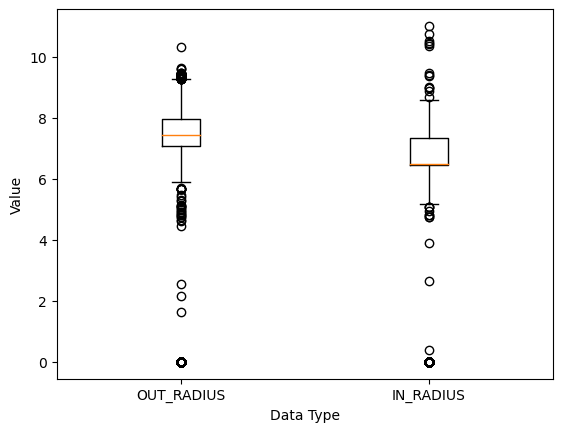

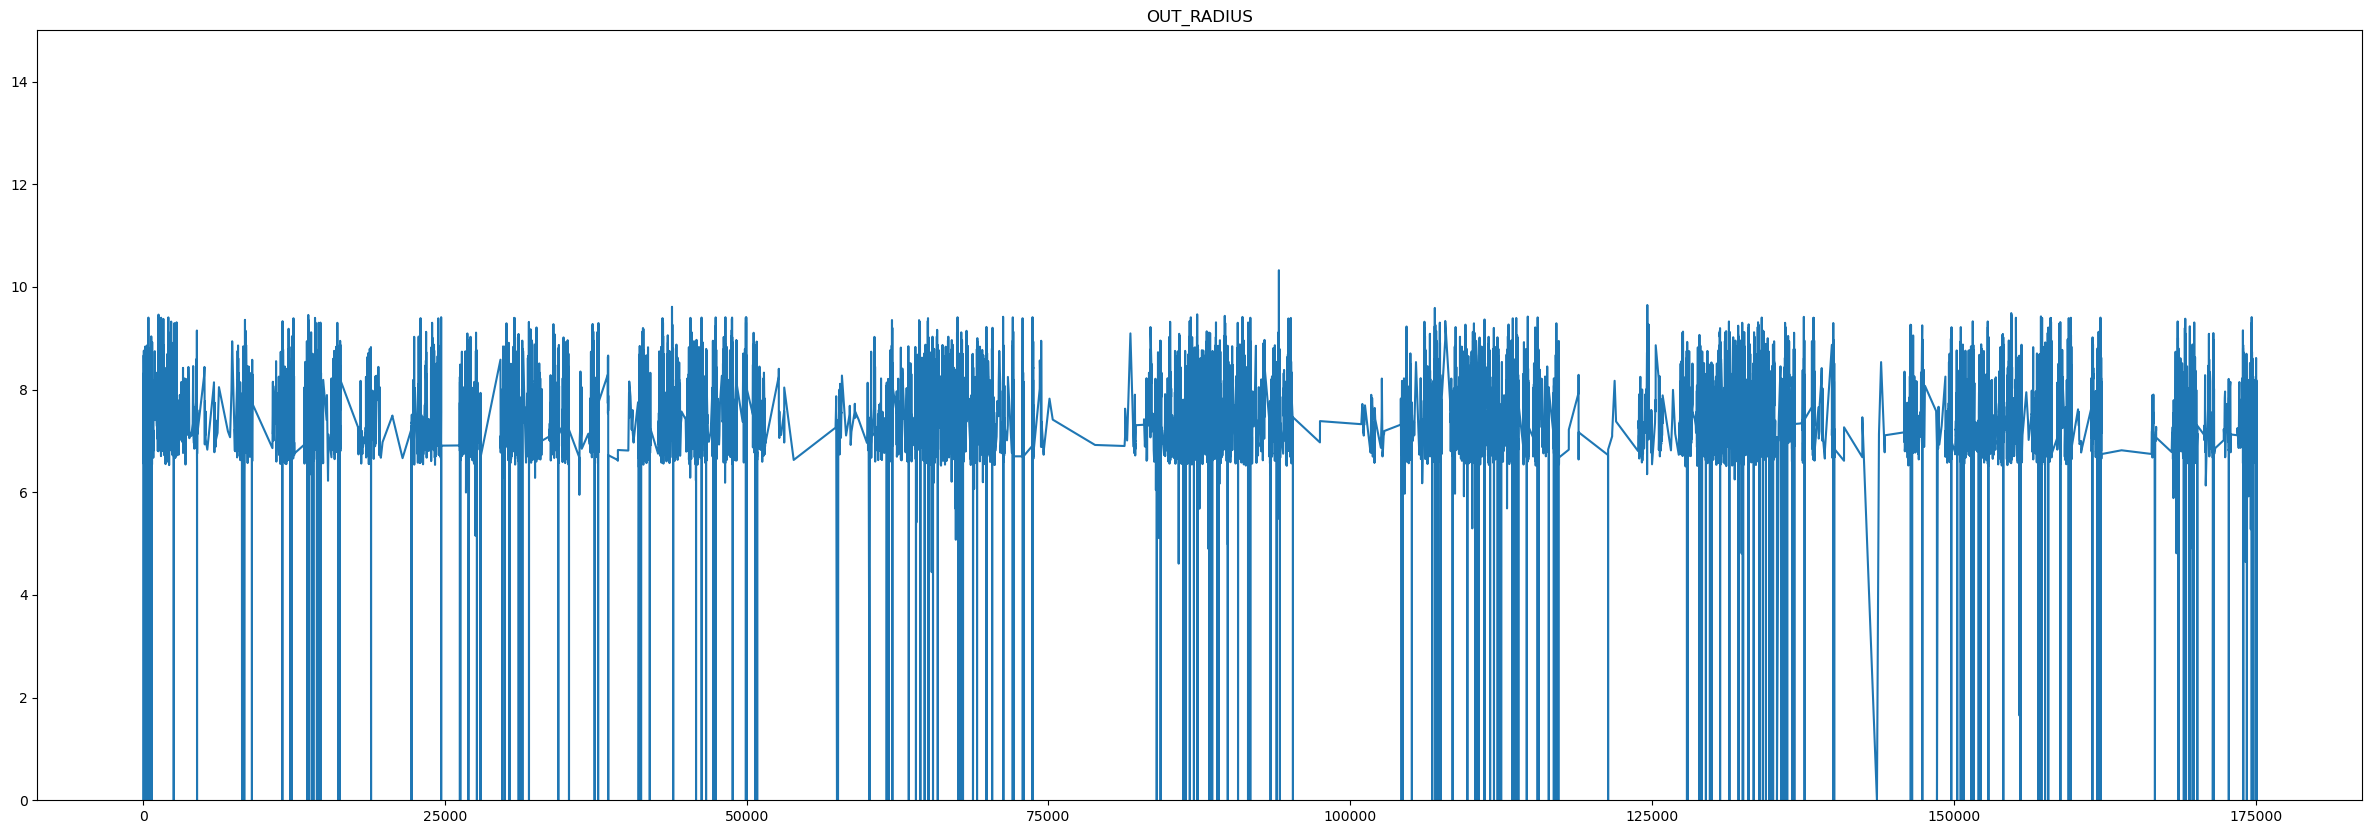

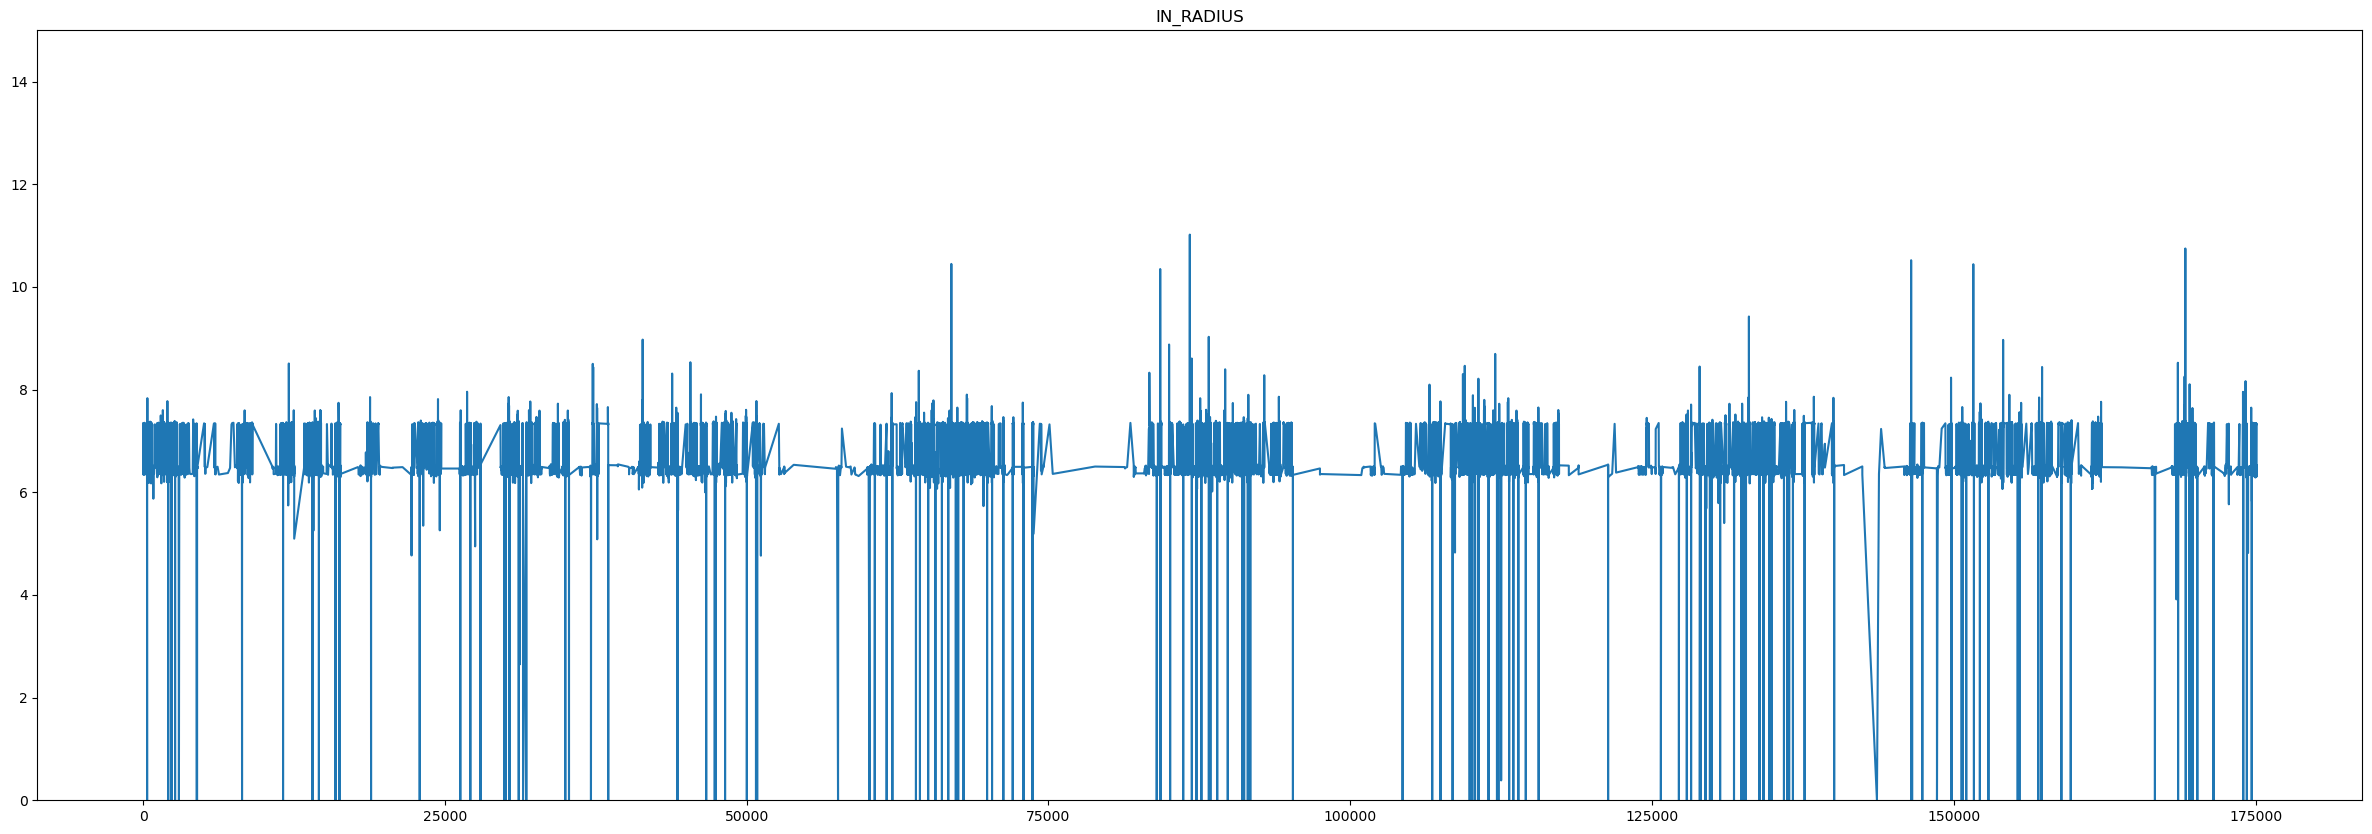

In [10]:
fig, ax = plt.subplots()

ax.boxplot([new_df['OUT_RADIUS'], new_df['IN_RADIUS']])
ax.set_xlabel('Data Type')
ax.set_ylabel('Value')
plt.xticks([1, 2], ['OUT_RADIUS','IN_RADIUS'])
plt.show()

plt.figure(figsize=(30,10))
plt.plot(new_df['OUT_RADIUS'])
plt.title('OUT_RADIUS')
plt.ylim([0,15])
plt.show()

plt.figure(figsize=(30,10))
plt.plot(new_df['IN_RADIUS'])
plt.title('IN_RADIUS')
plt.ylim([0,15])
plt.show()

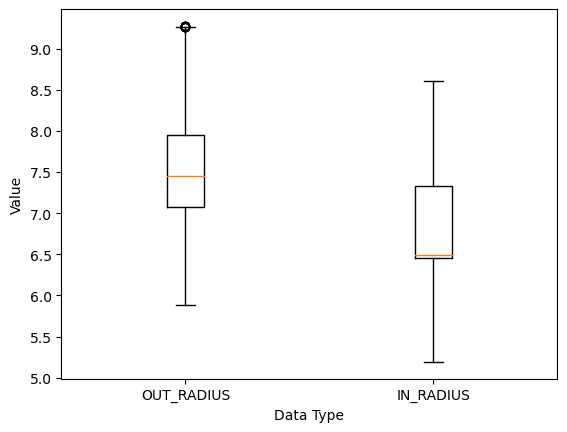

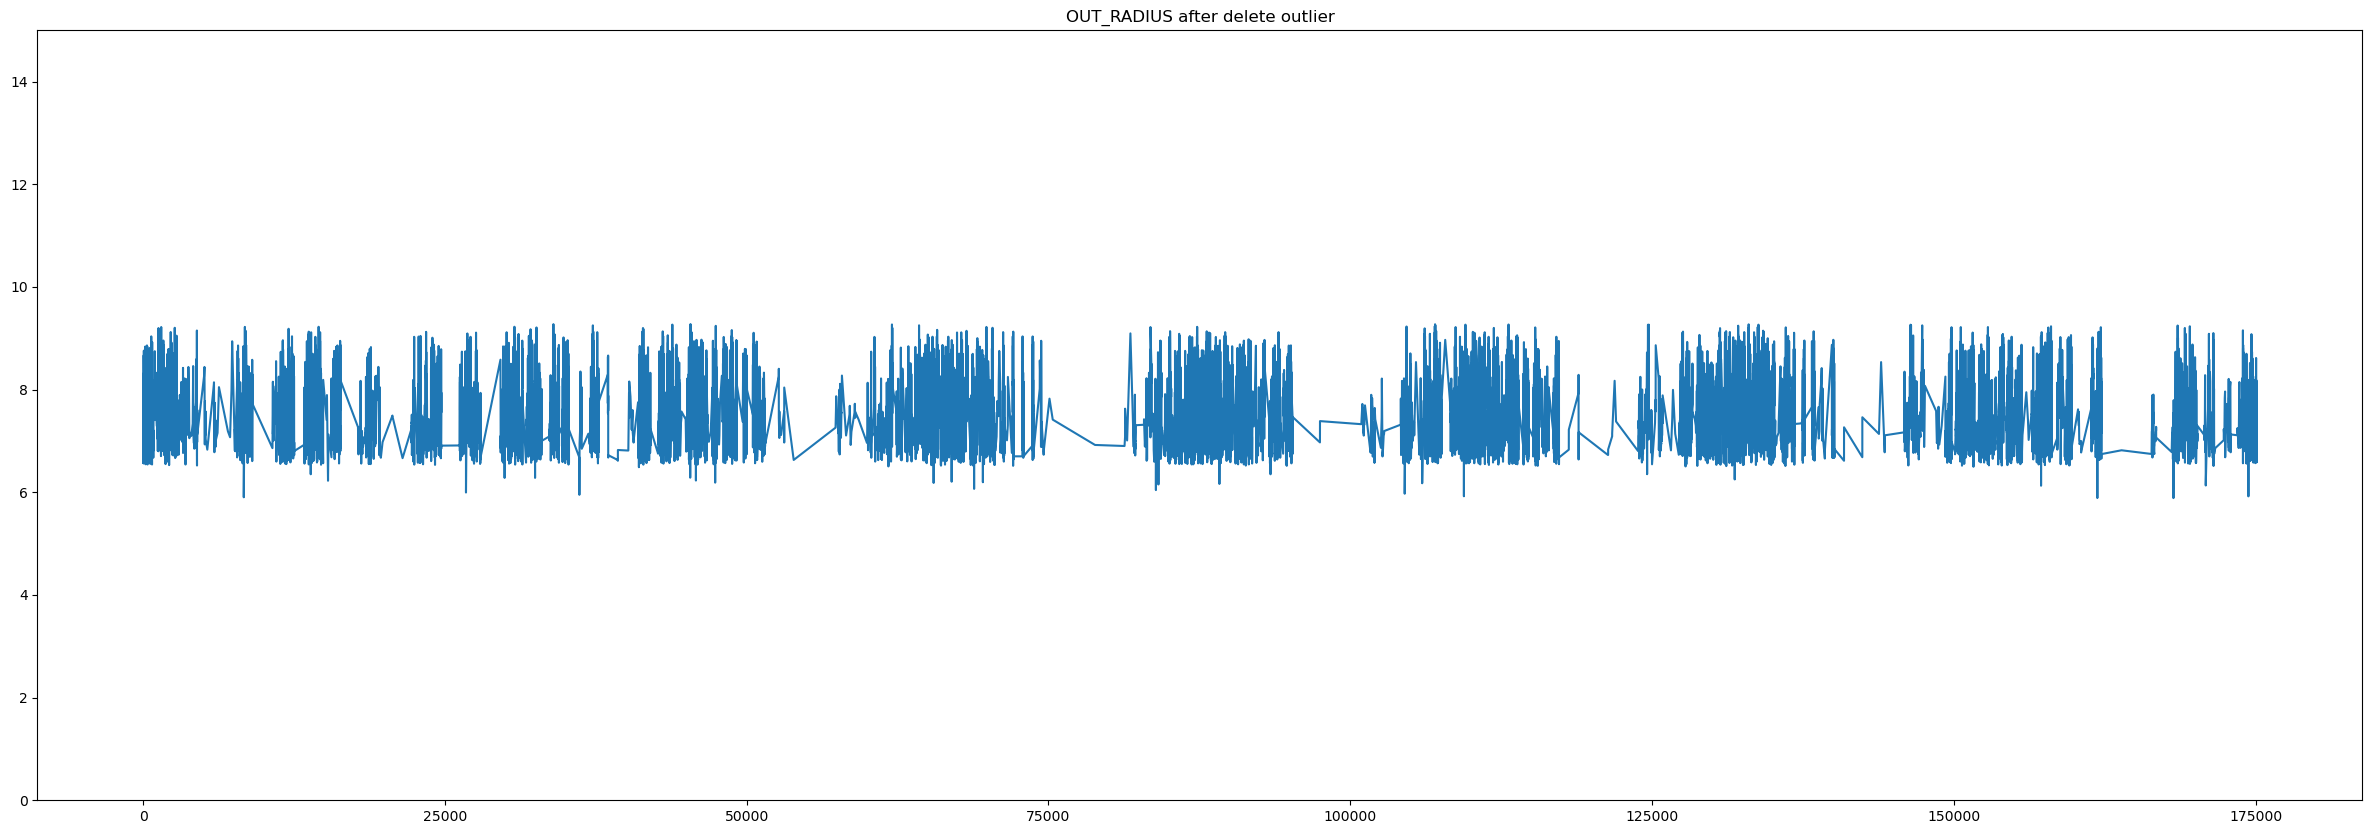

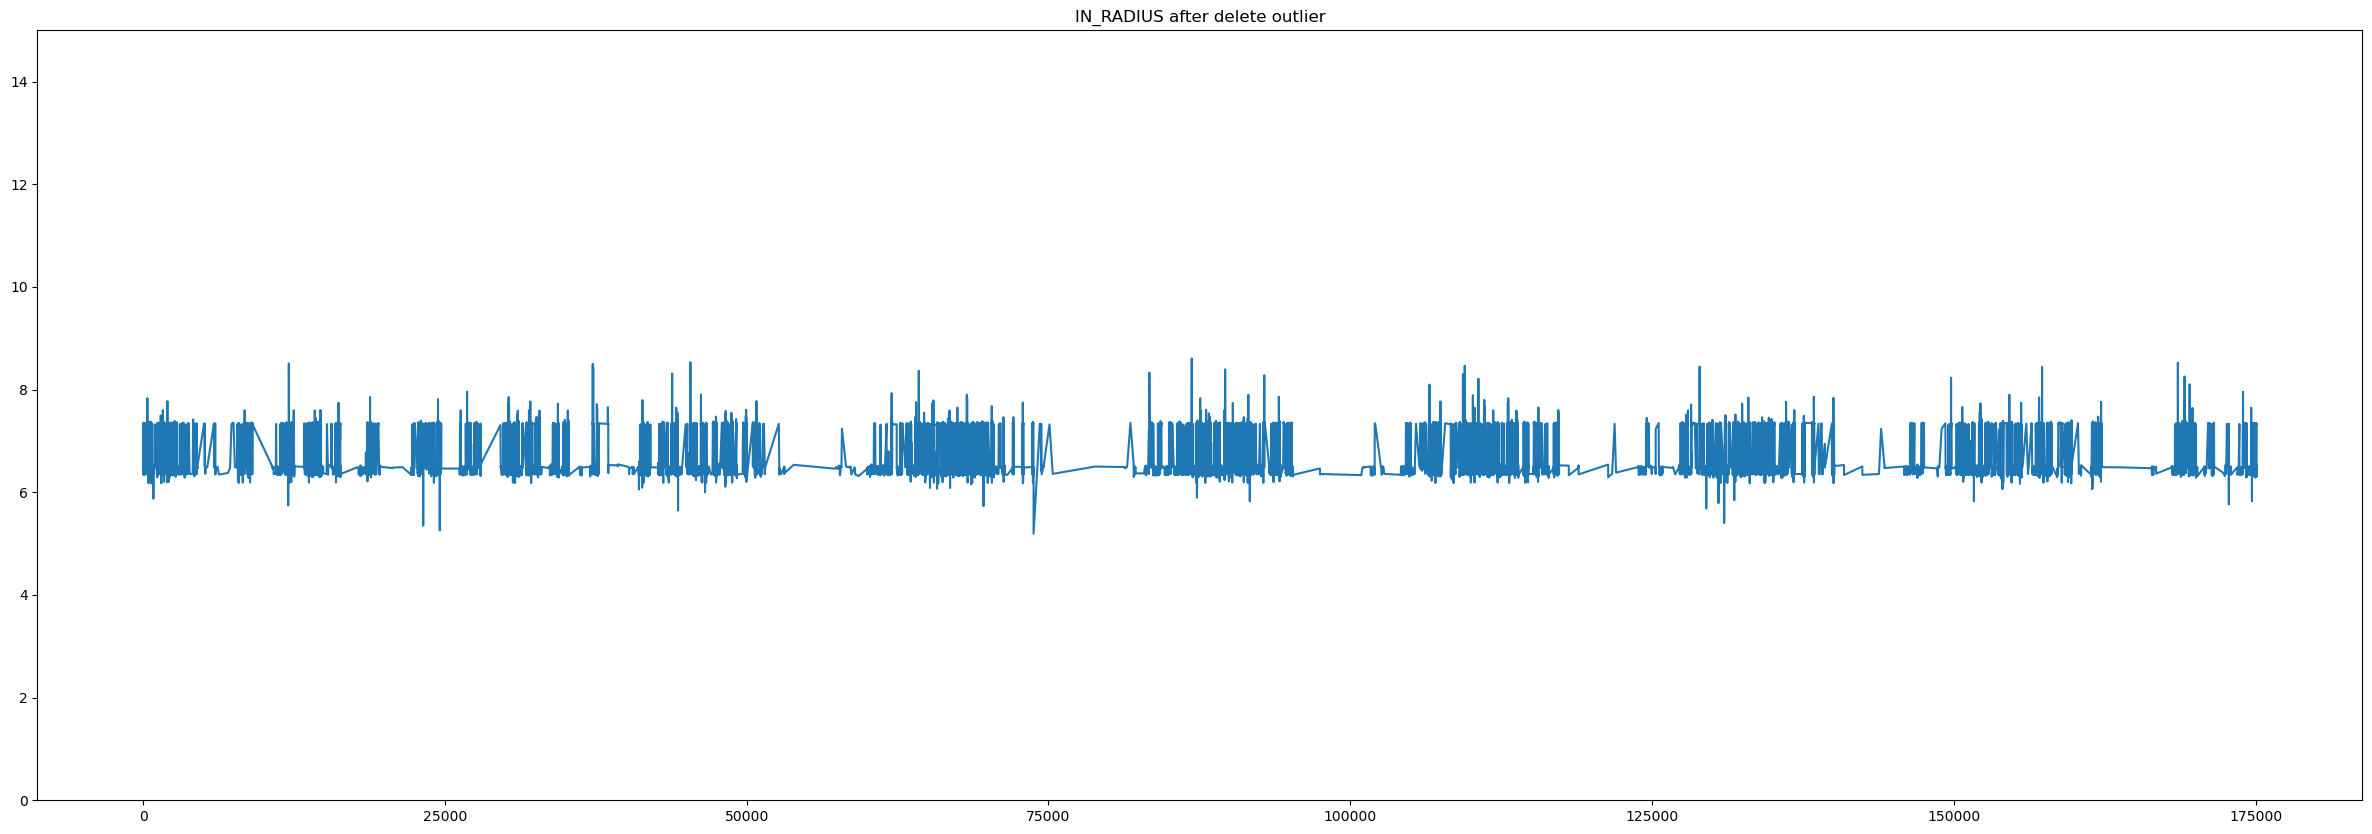

In [11]:
def get_outlier(df=None, column=None, weight=1.5):
  # target 값과 상관관계가 높은 열을 우선적으로 진행
    quantile_25 = np.percentile(df[column].values, 25)
    quantile_75 = np.percentile(df[column].values, 75)

    IQR = quantile_75 - quantile_25
    IQR_weight = IQR*weight
  
    lowest = quantile_25 - IQR_weight
    highest = quantile_75 + IQR_weight
  
    outlier_idx = df[column][ (df[column] < lowest) | (df[column] > highest) ].index
    return outlier_idx

# 함수 사용해서 이상치 값 삭제
outlier_idx_in_rad = get_outlier(df=new_df, column='IN_RADIUS', weight=1.5)
new_df = new_df.drop(outlier_idx_in_rad,axis=0)
outlier_idx_out_rad = get_outlier(df=new_df, column='OUT_RADIUS', weight=1.5)
new_df = new_df.drop(outlier_idx_out_rad,axis=0)

outlier_idx_in_rad = get_outlier(df=anomaly_df, column='IN_RADIUS', weight=1.5)
anomaly_df = anomaly_df.drop(outlier_idx_in_rad,axis=0)
outlier_idx_out_rad = get_outlier(df=anomaly_df, column='OUT_RADIUS', weight=1.5)
anomaly_df = anomaly_df.drop(outlier_idx_out_rad,axis=0)

fig, ax = plt.subplots()

ax.boxplot([new_df['OUT_RADIUS'], new_df['IN_RADIUS']])
ax.set_xlabel('Data Type')
ax.set_ylabel('Value')
plt.xticks([1, 2], ['OUT_RADIUS','IN_RADIUS'])
plt.show()

plt.figure(figsize=(30,10))
plt.plot(new_df['OUT_RADIUS'])
plt.title('OUT_RADIUS after delete outlier')
plt.ylim([0,15])
plt.show()

plt.figure(figsize=(30,10))
plt.plot(new_df['IN_RADIUS'])
plt.title('IN_RADIUS after delete outlier')
plt.ylim([0,15])
plt.show()

In [12]:
new_df['target'] = 0
anomaly_df['target'] = 1

In [13]:
new_df

,EQUIP_ID,MOLD_POS,REAL_POWER,MOLD_IN_TOP,MOLD_IN_BOT,MOLD_OUT_TOP,MOLD_OUT_BOT,IN_RADIUS,OUT_RADIUS,POWER,POWER1,POWER2,POWER3,POWER4,POWER5,target
1,EQUIP2,1,-6.50,CORE1 B 02. 0550,CORE1 B 01. P2+1,CORE1 B 02. M1050,CORE1 B 02. C-10,6.3564,7.4551,-6.50,-6.25,-6.25,-6.37,-6.50,-6.50,0
3,EQUIP2,6,-7.50,CORE1 B 02. 0550,CORE1 B 01. P2+1,CORE1 B 02. M1250,CORE1 B 02. C-12,6.3600,7.6877,-7.50,-7.50,-7.50,-7.62,-7.62,-7.62,0
4,EQUIP3,1,-0.75,CORE3 C 01. 0660,CORE3 C 01. OK+2,CORE3 C 03. M0125,CORE3 C 03. B-01,7.3411,7.5236,-0.75,-0.87,-0.87,-0.87,-0.87,-0.87,0
5,EQUIP4,8,-4.00,CORE1 A 02. 0570,CORE1 A 01. P1+2,CORE1 A 05. M0650,CORE1 A 08. C-06,6.4829,7.1508,-4.00,-4.00,-3.87,-3.87,-4.12,-4.12,0
6,EQUIP5,6,-8.50,CORE1 A 02. 0570,CORE1 A 01. P3+2,CORE1 A 05. M1550,CORE1 A 08. C-15,6.4800,8.2939,-8.50,-8.25,-8.25,-8.37,-8.37,-8.37,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175095,EQUIP37,1,-4.00,CORE5 F 01. 0570,CORE5 F 01. OK+1,CORE5 F 02. M0675,CORE5 F 02. D-06,6.3326,6.9997,-4.00,-4.12,-4.12,-4.00,-4.00,-4.00,0
175096,EQUIP37,8,-4.75,CORE5 F 01. 0570,CORE5 F 01. OK+2,CORE5 F 02. M0775,CORE5 F 02. D-07,6.3279,7.0979,-4.75,-4.75,-4.75,-4.75,-4.75,-4.75,0
175097,EQUIP13,4,-5.25,CORE5 F 01. 0570,CORE5 F 01. OK+0,CORE5 F 02. M0850,CORE5 F 02. C-08,6.3304,7.1881,-5.25,-5.25,-5.25,-5.25,-5.25,-5.25,0
175098,EQUIP13,5,-5.25,CORE5 F 01. 0570,CORE5 F 01. OK+2,CORE5 F 02. M0875,CORE5 F 02. D-08,6.4933,6.8071,-5.25,-5.12,-5.12,-5.25,-5.25,-5.25,0


In [14]:
anomaly_df

,EQUIP_ID,MOLD_POS,REAL_POWER,MOLD_IN_TOP,MOLD_IN_BOT,MOLD_OUT_TOP,MOLD_OUT_BOT,IN_RADIUS,OUT_RADIUS,POWER,POWER1,POWER2,POWER3,POWER4,POWER5,target
121,EQUIP15,4,-3.25,CORE1 A 02. 0570,CORE1 A 01. P2+2,CORE1 A 05. M0625,CORE1 A 08. B-06,6.4741,7.1521,-3.50,-3.37,-3.37,-3.50,-3.50,-3.50,1
2297,EQUIP27,2,-8.00,CORE2 C 03. 0660,CORE2 C 03. P1-2,CORE2 C 04. M0475,CORE2 C 04. D-04,7.3455,7.9546,-3.50,-3.50,-3.50,-3.37,-3.37,-3.37,1
2893,EQUIP13,7,-5.00,CORE1 B 02. 0550,CORE1 B 01. P2+0,CORE1 B 02. M0850,CORE1 B 02. C-08,7.2074,6.3643,-5.25,-5.25,-5.25,-5.25,-5.00,-5.00,1
3175,EQUIP26,6,-6.00,CORE2 C 03. 0660,CORE2 C 03. OK+2,CORE2 C 04. M0925,CORE2 C 04. B-09,8.5852,7.3512,-6.50,-6.50,-6.65,-6.75,-6.75,-6.75,1
4051,EQUIP2,3,-3.75,CORE3 C 01. 0660,CORE3 C 01. P1-1,CORE3 C 03. M0525,CORE3 C 03. B-05,8.0007,7.3452,-3.50,-3.50,-3.62,-3.62,-3.62,-3.62,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174123,EQUIP33,3,-5.25,CORE5 F 01. 0570,CORE5 F 01. OK+0,CORE5 F 02. M0825,CORE5 F 02. B-08,7.1685,6.2684,-5.50,-5.50,-5.62,-5.62,-5.62,-5.62,1
174238,EQUIP16,5,-2.50,CORE2 C 03. 0660,CORE2 C 03. P1+0,CORE2 C 04. M0325,CORE2 C 04. B-03,7.3764,7.7534,-2.25,-2.25,-2.25,-2.25,-2.25,-2.37,1
174257,EQUIP12,6,-1.75,CORE5 E 01. 0590,CORE5 E 01. M2+0,CORE5 E 02. M0300,CORE5 E 02. A-03,6.5082,6.8625,-2.25,-2.25,-2.25,-2.12,-2.12,-2.12,1
174862,EQUIP7,8,-4.00,CORE5 E 01. 0590,CORE5 E 01. M1+0,CORE5 E 02. M0650,CORE5 E 02. C-06,6.5094,7.2148,-4.25,-4.25,-4.25,-4.25,-4.37,-4.37,1


In [15]:
data_df = pd.concat([new_df,anomaly_df])
data_df

,EQUIP_ID,MOLD_POS,REAL_POWER,MOLD_IN_TOP,MOLD_IN_BOT,MOLD_OUT_TOP,MOLD_OUT_BOT,IN_RADIUS,OUT_RADIUS,POWER,POWER1,POWER2,POWER3,POWER4,POWER5,target
1,EQUIP2,1,-6.50,CORE1 B 02. 0550,CORE1 B 01. P2+1,CORE1 B 02. M1050,CORE1 B 02. C-10,6.3564,7.4551,-6.50,-6.25,-6.25,-6.37,-6.50,-6.50,0
3,EQUIP2,6,-7.50,CORE1 B 02. 0550,CORE1 B 01. P2+1,CORE1 B 02. M1250,CORE1 B 02. C-12,6.3600,7.6877,-7.50,-7.50,-7.50,-7.62,-7.62,-7.62,0
4,EQUIP3,1,-0.75,CORE3 C 01. 0660,CORE3 C 01. OK+2,CORE3 C 03. M0125,CORE3 C 03. B-01,7.3411,7.5236,-0.75,-0.87,-0.87,-0.87,-0.87,-0.87,0
5,EQUIP4,8,-4.00,CORE1 A 02. 0570,CORE1 A 01. P1+2,CORE1 A 05. M0650,CORE1 A 08. C-06,6.4829,7.1508,-4.00,-4.00,-3.87,-3.87,-4.12,-4.12,0
6,EQUIP5,6,-8.50,CORE1 A 02. 0570,CORE1 A 01. P3+2,CORE1 A 05. M1550,CORE1 A 08. C-15,6.4800,8.2939,-8.50,-8.25,-8.25,-8.37,-8.37,-8.37,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174123,EQUIP33,3,-5.25,CORE5 F 01. 0570,CORE5 F 01. OK+0,CORE5 F 02. M0825,CORE5 F 02. B-08,7.1685,6.2684,-5.50,-5.50,-5.62,-5.62,-5.62,-5.62,1
174238,EQUIP16,5,-2.50,CORE2 C 03. 0660,CORE2 C 03. P1+0,CORE2 C 04. M0325,CORE2 C 04. B-03,7.3764,7.7534,-2.25,-2.25,-2.25,-2.25,-2.25,-2.37,1
174257,EQUIP12,6,-1.75,CORE5 E 01. 0590,CORE5 E 01. M2+0,CORE5 E 02. M0300,CORE5 E 02. A-03,6.5082,6.8625,-2.25,-2.25,-2.25,-2.12,-2.12,-2.12,1
174862,EQUIP7,8,-4.00,CORE5 E 01. 0590,CORE5 E 01. M1+0,CORE5 E 02. M0650,CORE5 E 02. C-06,6.5094,7.2148,-4.25,-4.25,-4.25,-4.25,-4.37,-4.37,1


In [16]:
data_df['POWER_MEAN'] = (data_df['POWER1'] + data_df['POWER2'] + data_df['POWER3'] + data_df['POWER4'] + data_df['POWER5']) / 5
df_final = data_df.drop(['POWER_MEAN','REAL_POWER','POWER1','POWER2','POWER3','POWER4','POWER5','MOLD_IN_TOP','MOLD_IN_BOT','MOLD_OUT_TOP','MOLD_OUT_BOT'],axis=1)
df_final

,EQUIP_ID,MOLD_POS,IN_RADIUS,OUT_RADIUS,POWER,target
1,EQUIP2,1,6.3564,7.4551,-6.50,0
3,EQUIP2,6,6.3600,7.6877,-7.50,0
4,EQUIP3,1,7.3411,7.5236,-0.75,0
5,EQUIP4,8,6.4829,7.1508,-4.00,0
6,EQUIP5,6,6.4800,8.2939,-8.50,0
...,...,...,...,...,...,...
174123,EQUIP33,3,7.1685,6.2684,-5.50,1
174238,EQUIP16,5,7.3764,7.7534,-2.25,1
174257,EQUIP12,6,6.5082,6.8625,-2.25,1
174862,EQUIP7,8,6.5094,7.2148,-4.25,1


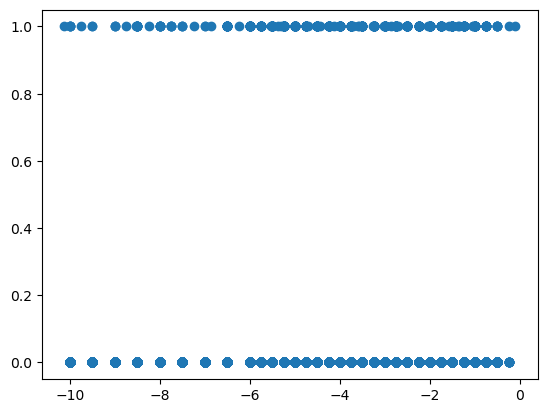

In [17]:
plt.scatter(df_final['POWER'], df_final['target'])

In [18]:
df_encoded = df_final

In [20]:
#df_encoded = pd.get_dummies(df_final,columns=['MOLD_POS','EQUIP_ID','MOLD_IN_TOP','MOLD_IN_BOT',"MOLD_OUT_TOP",'MOLD_OUT_BOT'])
df_encoded = pd.get_dummies(df_final,columns=['EQUIP_ID','MOLD_POS'])
df_encoded.reset_index(drop=True, inplace=True)
df_encoded

,IN_RADIUS,OUT_RADIUS,POWER,target,EQUIP_ID_EQUIP1,EQUIP_ID_EQUIP10,EQUIP_ID_EQUIP11,EQUIP_ID_EQUIP12,EQUIP_ID_EQUIP13,EQUIP_ID_EQUIP14,...,MOLD_POS_5,MOLD_POS_6,MOLD_POS_7,MOLD_POS_8,MOLD_POS_9,MOLD_POS_10,MOLD_POS_11,MOLD_POS_12,MOLD_POS_14,MOLD_POS_15
0,6.3564,7.4551,-6.50,0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,6.3600,7.6877,-7.50,0,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
2,7.3411,7.5236,-0.75,0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,6.4829,7.1508,-4.00,0,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
4,6.4800,8.2939,-8.50,0,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28588,7.1685,6.2684,-5.50,1,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
28589,7.3764,7.7534,-2.25,1,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
28590,6.5082,6.8625,-2.25,1,False,False,False,True,False,False,...,False,True,False,False,False,False,False,False,False,False
28591,6.5094,7.2148,-4.25,1,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False


In [21]:
df_encoded_normal = df_encoded.loc[df_encoded['target'] == 0]
df_encoded_anomaly = df_encoded.loc[df_encoded['target'] == 1]

In [22]:
df_encoded_anomaly

,IN_RADIUS,OUT_RADIUS,POWER,target,EQUIP_ID_EQUIP1,EQUIP_ID_EQUIP10,EQUIP_ID_EQUIP11,EQUIP_ID_EQUIP12,EQUIP_ID_EQUIP13,EQUIP_ID_EQUIP14,...,MOLD_POS_5,MOLD_POS_6,MOLD_POS_7,MOLD_POS_8,MOLD_POS_9,MOLD_POS_10,MOLD_POS_11,MOLD_POS_12,MOLD_POS_14,MOLD_POS_15
28070,6.4741,7.1521,-3.50,1,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
28071,7.3455,7.9546,-3.50,1,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
28072,7.2074,6.3643,-5.25,1,False,False,False,False,True,False,...,False,False,True,False,False,False,False,False,False,False
28073,8.5852,7.3512,-6.50,1,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
28074,8.0007,7.3452,-3.50,1,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28588,7.1685,6.2684,-5.50,1,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
28589,7.3764,7.7534,-2.25,1,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
28590,6.5082,6.8625,-2.25,1,False,False,False,True,False,False,...,False,True,False,False,False,False,False,False,False,False
28591,6.5094,7.2148,-4.25,1,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False


In [23]:
df_x = df_encoded_normal.drop('target',axis=1)

#df_y = df_encoded['POWER_MEAN']
#df_x = df_encoded.drop('POWER_MEAN',axis=1)
#df_y = df_encoded['REAL_POWER']
#df_x = df_encoded.drop('REAL_POWER',axis=1)

In [24]:
df_x

,IN_RADIUS,OUT_RADIUS,POWER,EQUIP_ID_EQUIP1,EQUIP_ID_EQUIP10,EQUIP_ID_EQUIP11,EQUIP_ID_EQUIP12,EQUIP_ID_EQUIP13,EQUIP_ID_EQUIP14,EQUIP_ID_EQUIP15,...,MOLD_POS_5,MOLD_POS_6,MOLD_POS_7,MOLD_POS_8,MOLD_POS_9,MOLD_POS_10,MOLD_POS_11,MOLD_POS_12,MOLD_POS_14,MOLD_POS_15
0,6.3564,7.4551,-6.50,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,6.3600,7.6877,-7.50,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
2,7.3411,7.5236,-0.75,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,6.4829,7.1508,-4.00,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
4,6.4800,8.2939,-8.50,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28065,6.3326,6.9997,-4.00,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
28066,6.3279,7.0979,-4.75,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
28067,6.3304,7.1881,-5.25,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
28068,6.4933,6.8071,-5.25,False,False,False,False,True,False,False,...,True,False,False,False,False,False,False,False,False,False


In [25]:
train_x, val_x = train_test_split(df_x, test_size = 0.2,random_state=SEED)
train_x.reset_index(drop=True, inplace=True)
val_x.reset_index(drop=True, inplace=True)

val_x, test_x = train_test_split(val_x, test_size = 0.5, random_state=SEED)
val_x.reset_index(drop=True, inplace=True)
test_x.reset_index(drop=True, inplace=True)

scaler = MinMaxScaler()
train_x = scaler.fit_transform(train_x)
val_x = scaler.transform(val_x)
test_x = scaler.transform(test_x)

In [26]:
print(train_x.shape)
print(val_x.shape)
print(test_x.shape)

(22456, 55)
(2807, 55)
(2807, 55)


In [27]:
class MyDataset(Dataset):
    def __init__(self, origin_x):
        self.data = origin_x
        
    def __getitem__(self, index):
        self.x = self.data[index]
        return torch.Tensor(self.x)

    def __len__(self):
        return len(self.data)

#Pytorch를 사용하기 위해 custom dataset 구성해줌

In [73]:
class AutoEncoder(nn.Module):
    def __init__(self,in_features):
        super(AutoEncoder, self).__init__()
        self.feature_num = in_features
        self.Encoder = nn.Sequential(
            nn.Linear(in_features,512),
            nn.ReLU(),
            nn.Linear(512,64),
            nn.ReLU(),
            nn.Linear(64,32),
            nn.ReLU(),
            nn.Linear(32,16),
            nn.ReLU(),

        )
        self.Decoder = nn.Sequential(
            nn.Linear(16,32),
            nn.ReLU(),
            nn.Linear(32,64),
            nn.ReLU(),
            nn.Linear(64,512),
            nn.ReLU(),
            nn.Linear(512,in_features),
        )

        self.init_weight()

    def forward(self, x):
        encoded = self.Encoder(x)
        decoded = self.Decoder(encoded)
        return decoded, encoded

    def init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant(m.weight, 1)
                nn.init.constant(m.bias, 0)

In [74]:
class Trainer():
    def __init__(self, model, optimizer, train_loader, val_loader, scheduler, device):
        self.model = model
        self.optimizer = optimizer
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.scheduler = scheduler
        self.device = device
        # Loss Function
        self.criterion = nn.MSELoss().to(self.device)
        
    def fit(self):
        self.model.to(self.device)
        best_loss = 1000000000
        for epoch in range(EPOCHS):
            self.model.train()
            train_loss = []
            i = 1
            for x in iter(self.train_loader):
                x = x.float().to(self.device)
                self.optimizer.zero_grad()
                _x,_ = self.model(x)
                loss = self.criterion(x,_x)
                loss.backward()
                self.optimizer.step()
                train_loss.append(loss.item())
                i=i+1
                
            val_loss, mse_list = self.validation(self.model)
            
            mean_train_loss = np.mean(train_loss)
            print(f'Epoch : [{epoch+1}] Train loss : [{mean_train_loss}] val loss : [{val_loss}]\n')
            self.scheduler.step(val_loss)
            
            if best_loss > val_loss:
                best_loss = val_loss
                torch.save(self.model, './' + MODEL_NAME+'.pth')
                print("SAVE MODEL ~_~")
                
        print(best_loss)
           
    def validation(self, eval_model):
        eval_model.eval()
        val_loss = []
        mse_list = []
        with torch.no_grad():
            for x in iter(self.val_loader):
                pred_tmp = []
                x = x.float().to(self.device)
                _x,_ = eval_model(x)
                error = x-_x
                mse = np.mean(np.power(error.numpy(),2),axis=1)
                loss = self.criterion(x,_x)
                val_loss.append(loss.item())
                mse_list += mse.tolist()
        return np.mean(val_loss), mse_list

In [75]:
train_x_tensor = torch.tensor(train_x)
val_x_tensor = torch.tensor(val_x)

In [76]:
train_dataset = MyDataset(train_x_tensor)
train_loader = DataLoader(train_dataset, batch_size=BS, shuffle=True)
val_dataset = MyDataset(val_x_tensor)
val_loader = DataLoader(val_dataset, batch_size=BS, shuffle=False)

In [77]:
it = iter(train_loader)
in_features = next(it)[0].shape[0]
in_features

55

In [78]:
#Train model
gc.collect()

seed_everything(SEED)
model = AutoEncoder(in_features)
#Using AdamW Optimizer
optimizer = torch.optim.Adam(params = model.parameters(), lr = LR)#Opimizer : AdamW
#Using Learning Rate Scheduler (ReduceLROnPlateau)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=20, threshold = 1e-8, threshold_mode='abs', min_lr=1e-8, verbose=True)
trainer = Trainer(model, optimizer, train_loader, val_loader, scheduler, device)
#trainer 객체 생성
trainer.fit()

Epoch : [1] Train loss : [0.016805536346510053] val loss : [0.010387797787023539]

SAVE MODEL ~_~
Epoch : [2] Train loss : [0.0069750342819908705] val loss : [0.004758026792180978]

SAVE MODEL ~_~
Epoch : [3] Train loss : [0.0035449790879765637] val loss : [0.0027039099460869857]

SAVE MODEL ~_~
Epoch : [4] Train loss : [0.0022611969666014244] val loss : [0.0019391535593471913]

SAVE MODEL ~_~
Epoch : [5] Train loss : [0.0016878012906391163] val loss : [0.0014253972410436043]

SAVE MODEL ~_~
Epoch : [6] Train loss : [0.0013865010073757398] val loss : [0.0012130298524756324]

SAVE MODEL ~_~
Epoch : [7] Train loss : [0.0011972912169821784] val loss : [0.0010755908264069478]

SAVE MODEL ~_~
Epoch : [8] Train loss : [0.0010761202820788994] val loss : [0.001029059347109234]

SAVE MODEL ~_~
Epoch : [9] Train loss : [0.000979563090658383] val loss : [0.0008972938812803477]

SAVE MODEL ~_~
Epoch : [10] Train loss : [0.0008733945808663933] val loss : [0.0008260347312898375]

SAVE MODEL ~_~
Epoc

Epoch : [91] Train loss : [0.0001688708533794769] val loss : [0.00018711049994056918]

Epoch : [92] Train loss : [0.00015272286633428243] val loss : [0.0001703316373261094]

Epoch : [93] Train loss : [0.00016326459555727818] val loss : [0.00017318323402419495]

Epoch : [94] Train loss : [0.00016218743148058165] val loss : [0.00013533014936745695]

SAVE MODEL ~_~
Epoch : [95] Train loss : [0.00015150266677727247] val loss : [0.00016189840392722874]

Epoch : [96] Train loss : [0.0001726822716239017] val loss : [0.00013523106934537117]

SAVE MODEL ~_~
Epoch : [97] Train loss : [0.00014668934906572848] val loss : [0.0001752216373709168]

Epoch : [98] Train loss : [0.0001704409232454645] val loss : [0.00016395428271855715]

Epoch : [99] Train loss : [0.00015452754968156085] val loss : [0.00018288701854048256]

Epoch : [100] Train loss : [0.00017110987377278055] val loss : [0.0001801735279514105]

Epoch : [101] Train loss : [0.00014101075874122478] val loss : [0.00016814927427979208]

Epoch 

Epoch : [182] Train loss : [3.811174126977829e-05] val loss : [4.7885494123792426e-05]

Epoch : [183] Train loss : [3.7957698957617475e-05] val loss : [5.2339694114132065e-05]

Epoch : [184] Train loss : [3.7495238577316105e-05] val loss : [4.892894480690302e-05]

Epoch : [185] Train loss : [3.708013757743713e-05] val loss : [4.6585893053154656e-05]

Epoch : [186] Train loss : [3.7186620695003376e-05] val loss : [4.849120874827019e-05]

Epoch : [187] Train loss : [3.623834835735887e-05] val loss : [4.554774210935813e-05]

SAVE MODEL ~_~
Epoch : [188] Train loss : [3.635225817934276e-05] val loss : [4.7347459588887766e-05]

Epoch : [189] Train loss : [3.550924893430974e-05] val loss : [4.795409267899231e-05]

Epoch : [190] Train loss : [3.57366070900421e-05] val loss : [4.5941163824119776e-05]

Epoch : [191] Train loss : [3.515832656539248e-05] val loss : [4.6941190413979875e-05]

Epoch : [192] Train loss : [3.5496748793783394e-05] val loss : [4.65945599898987e-05]

Epoch : [193] Train 

Epoch : [274] Train loss : [2.0779490585954153e-05] val loss : [3.484948836723395e-05]

Epoch : [275] Train loss : [2.095794389915319e-05] val loss : [3.513659904993719e-05]

Epoch : [276] Train loss : [2.0483848217096506e-05] val loss : [3.356939628867456e-05]

Epoch 00276: reducing learning rate of group 0 to 1.2500e-04.
Epoch : [277] Train loss : [1.1938639007093714e-05] val loss : [2.595915312688455e-05]

SAVE MODEL ~_~
Epoch : [278] Train loss : [1.2060738183669967e-05] val loss : [2.5064565105284682e-05]

SAVE MODEL ~_~
Epoch : [279] Train loss : [1.2459177944110499e-05] val loss : [2.592711546288807e-05]

Epoch : [280] Train loss : [1.2956297647137414e-05] val loss : [2.644197115841962e-05]

Epoch : [281] Train loss : [1.2746735817155238e-05] val loss : [2.606930461917562e-05]

Epoch : [282] Train loss : [1.276830806303786e-05] val loss : [2.6847246798214737e-05]

Epoch : [283] Train loss : [1.2701446082617082e-05] val loss : [2.5746476803140634e-05]

Epoch : [284] Train loss : 

Epoch : [364] Train loss : [9.090466592895356e-06] val loss : [2.2413448613695603e-05]

Epoch 00364: reducing learning rate of group 0 to 6.2500e-05.
Epoch : [365] Train loss : [6.2498852771970266e-06] val loss : [1.9291070654761906e-05]

SAVE MODEL ~_~
Epoch : [366] Train loss : [6.28154671785083e-06] val loss : [1.9872487340225316e-05]

Epoch : [367] Train loss : [6.4462187729828845e-06] val loss : [1.9958907929859297e-05]

Epoch : [368] Train loss : [6.478019805202599e-06] val loss : [1.942856824205757e-05]

Epoch : [369] Train loss : [6.526308391551504e-06] val loss : [1.9852794855007065e-05]

Epoch : [370] Train loss : [6.534774656510621e-06] val loss : [1.9648534512064295e-05]

Epoch : [371] Train loss : [6.50069377759771e-06] val loss : [1.943221570854803e-05]

Epoch : [372] Train loss : [6.458248135666436e-06] val loss : [1.934798622084021e-05]

Epoch : [373] Train loss : [6.439654001034299e-06] val loss : [1.9207550030325198e-05]

SAVE MODEL ~_~
Epoch : [374] Train loss : [6.3

Epoch : [455] Train loss : [5.274505890786084e-06] val loss : [1.752379771408579e-05]

SAVE MODEL ~_~
Epoch : [456] Train loss : [5.199063152719887e-06] val loss : [1.7719542980061803e-05]

Epoch : [457] Train loss : [5.236250234264406e-06] val loss : [1.758928029134536e-05]

Epoch : [458] Train loss : [5.267521300876792e-06] val loss : [1.838059835987141e-05]

Epoch : [459] Train loss : [5.312872263064678e-06] val loss : [1.802046732925853e-05]

Epoch : [460] Train loss : [5.0934828495390945e-06] val loss : [1.7951651570187593e-05]

Epoch : [461] Train loss : [5.234594232918858e-06] val loss : [1.79364092477127e-05]

Epoch : [462] Train loss : [5.176862383486774e-06] val loss : [1.772824683143881e-05]

Epoch : [463] Train loss : [5.241975389725229e-06] val loss : [1.790539942383227e-05]

Epoch : [464] Train loss : [5.086107810444949e-06] val loss : [1.798350054245516e-05]

Epoch : [465] Train loss : [5.200926014554287e-06] val loss : [1.8238485877604532e-05]

Epoch : [466] Train loss 

Epoch : [546] Train loss : [3.599097135779539e-06] val loss : [1.5970926896939503e-05]

SAVE MODEL ~_~
Epoch : [547] Train loss : [3.5916651690540598e-06] val loss : [1.626376901113376e-05]

Epoch : [548] Train loss : [3.5875102872896837e-06] val loss : [1.5983938838685802e-05]

Epoch : [549] Train loss : [3.5900720614696195e-06] val loss : [1.5974941618424054e-05]

Epoch : [550] Train loss : [3.5686285364563523e-06] val loss : [1.596987168413348e-05]

SAVE MODEL ~_~
Epoch : [551] Train loss : [3.598139070724582e-06] val loss : [1.5955666627447002e-05]

SAVE MODEL ~_~
Epoch : [552] Train loss : [3.5588566037536384e-06] val loss : [1.584810610727965e-05]

SAVE MODEL ~_~
Epoch : [553] Train loss : [3.588815883614626e-06] val loss : [1.6126694062408703e-05]

Epoch : [554] Train loss : [3.565991880222077e-06] val loss : [1.5969311647268114e-05]

Epoch : [555] Train loss : [3.5664746191509963e-06] val loss : [1.5908898058631333e-05]

Epoch : [556] Train loss : [3.530265440528775e-06] val lo

Epoch : [637] Train loss : [3.1901708408593633e-06] val loss : [1.5189190725870752e-05]

Epoch : [638] Train loss : [3.1974308975392896e-06] val loss : [1.5372652125155252e-05]

Epoch : [639] Train loss : [3.177233197429218e-06] val loss : [1.557454206523413e-05]

Epoch : [640] Train loss : [3.213449321475099e-06] val loss : [1.537567427011378e-05]

Epoch : [641] Train loss : [3.17097097919301e-06] val loss : [1.539241961397279e-05]

Epoch : [642] Train loss : [3.2017276335939297e-06] val loss : [1.5243331808598917e-05]

Epoch : [643] Train loss : [3.1693276408121557e-06] val loss : [1.526618800085089e-05]

Epoch : [644] Train loss : [3.1907157852743758e-06] val loss : [1.538437176923873e-05]

Epoch : [645] Train loss : [3.1480791207910996e-06] val loss : [1.52918099199827e-05]

Epoch : [646] Train loss : [3.1577417444090797e-06] val loss : [1.5294873731167254e-05]

Epoch : [647] Train loss : [3.1895827547186412e-06] val loss : [1.5202910267413989e-05]

Epoch : [648] Train loss : [3.16

Epoch : [728] Train loss : [2.5844435332765817e-06] val loss : [1.46354047103614e-05]

Epoch : [729] Train loss : [2.5900955618653253e-06] val loss : [1.4577441892139507e-05]

Epoch : [730] Train loss : [2.589449233730913e-06] val loss : [1.4525759061195293e-05]

SAVE MODEL ~_~
Epoch : [731] Train loss : [2.57601273164711e-06] val loss : [1.4613114402095562e-05]

Epoch : [732] Train loss : [2.5744724141085085e-06] val loss : [1.4609756222098854e-05]

Epoch : [733] Train loss : [2.5924997600961375e-06] val loss : [1.461647289602297e-05]

Epoch : [734] Train loss : [2.580192140051148e-06] val loss : [1.4593801974559607e-05]

Epoch : [735] Train loss : [2.5720040645976504e-06] val loss : [1.4450203359863487e-05]

SAVE MODEL ~_~
Epoch : [736] Train loss : [2.577329117047289e-06] val loss : [1.4602950894403545e-05]

Epoch : [737] Train loss : [2.5667772586289216e-06] val loss : [1.4540922627113353e-05]

Epoch : [738] Train loss : [2.5619725075146954e-06] val loss : [1.4494533774919463e-05]


Epoch : [818] Train loss : [2.2972041686449026e-06] val loss : [1.4203897622037816e-05]

Epoch : [819] Train loss : [2.2980216529612935e-06] val loss : [1.4267549575079515e-05]

Epoch : [820] Train loss : [2.300705870294661e-06] val loss : [1.4199892208663103e-05]

Epoch : [821] Train loss : [2.2970702129177335e-06] val loss : [1.4229742796280995e-05]

Epoch : [822] Train loss : [2.297777835586014e-06] val loss : [1.4247899776685038e-05]

Epoch : [823] Train loss : [2.2949277670515605e-06] val loss : [1.427308299768852e-05]

Epoch : [824] Train loss : [2.295505414408542e-06] val loss : [1.4220924490680112e-05]

Epoch : [825] Train loss : [2.292628767608068e-06] val loss : [1.4254044983049011e-05]

Epoch : [826] Train loss : [2.292801271837393e-06] val loss : [1.4294705962925036e-05]

Epoch : [827] Train loss : [2.288407554756188e-06] val loss : [1.4272361092728467e-05]

Epoch : [828] Train loss : [2.2884291567128785e-06] val loss : [1.4224726958838636e-05]

Epoch : [829] Train loss : [

Epoch : [907] Train loss : [2.128634245218175e-06] val loss : [1.4046537847372582e-05]

Epoch : [908] Train loss : [2.1283937331824363e-06] val loss : [1.4038613498841682e-05]

Epoch : [909] Train loss : [2.1269140291093323e-06] val loss : [1.4040858338469e-05]

Epoch : [910] Train loss : [2.12878744179484e-06] val loss : [1.4030918030336828e-05]

Epoch : [911] Train loss : [2.128133245786301e-06] val loss : [1.4035192367342377e-05]

Epoch : [912] Train loss : [2.1267515676222074e-06] val loss : [1.4029290582584508e-05]

Epoch : [913] Train loss : [2.126619190635975e-06] val loss : [1.406129011110641e-05]

Epoch : [914] Train loss : [2.1258556312904357e-06] val loss : [1.4049023647544345e-05]

Epoch : [915] Train loss : [2.126992355048925e-06] val loss : [1.404467121672455e-05]

Epoch : [916] Train loss : [2.126056556662376e-06] val loss : [1.4022729155788676e-05]

SAVE MODEL ~_~
Epoch : [917] Train loss : [2.1251675189515633e-06] val loss : [1.4043224264913658e-05]

Epoch : [918] Trai

Epoch : [996] Train loss : [2.077772442562569e-06] val loss : [1.3998053117606188e-05]

Epoch : [997] Train loss : [2.0781349566889154e-06] val loss : [1.4001489499936394e-05]

Epoch : [998] Train loss : [2.077818264512159e-06] val loss : [1.4001474379586977e-05]

Epoch : [999] Train loss : [2.077608752302109e-06] val loss : [1.3999410134085172e-05]

Epoch : [1000] Train loss : [2.078368405970347e-06] val loss : [1.3995441951857918e-05]

Epoch : [1001] Train loss : [2.0778316575342095e-06] val loss : [1.3998481643346333e-05]

Epoch : [1002] Train loss : [2.0782191971781432e-06] val loss : [1.3997533192816098e-05]

Epoch : [1003] Train loss : [2.0777706544240805e-06] val loss : [1.3994478016663628e-05]

Epoch : [1004] Train loss : [2.080283075398733e-06] val loss : [1.3997550665707918e-05]

Epoch : [1005] Train loss : [2.0779064579672304e-06] val loss : [1.399523215313407e-05]

Epoch : [1006] Train loss : [2.0776966204865057e-06] val loss : [1.3995130453798248e-05]

Epoch : [1007] Train

Epoch : [1085] Train loss : [2.071169247701774e-06] val loss : [1.3995445306911527e-05]

Epoch : [1086] Train loss : [2.0705529460912055e-06] val loss : [1.3995503946065666e-05]

Epoch : [1087] Train loss : [2.0708431395989226e-06] val loss : [1.3995478580981894e-05]

Epoch : [1088] Train loss : [2.071297143693767e-06] val loss : [1.3995474775056623e-05]

Epoch : [1089] Train loss : [2.070708543937937e-06] val loss : [1.3995364682273248e-05]

Epoch : [1090] Train loss : [2.0705895255600045e-06] val loss : [1.3995430766623361e-05]

Epoch : [1091] Train loss : [2.0706977423118034e-06] val loss : [1.3995550854805185e-05]

Epoch : [1092] Train loss : [2.0707173522386543e-06] val loss : [1.3995558382682496e-05]

Epoch : [1093] Train loss : [2.0707823028084266e-06] val loss : [1.399547077793076e-05]

Epoch : [1094] Train loss : [2.0707184640862106e-06] val loss : [1.3995526574913955e-05]

Epoch : [1095] Train loss : [2.0708246484023777e-06] val loss : [1.3995565510072083e-05]

Epoch : [1096]

Epoch : [1177] Train loss : [2.0714448767433654e-06] val loss : [1.3995875674895201e-05]

Epoch : [1178] Train loss : [2.0719293363598214e-06] val loss : [1.3995889213964057e-05]

Epoch : [1179] Train loss : [2.0708163711260774e-06] val loss : [1.3995957848516644e-05]

Epoch : [1180] Train loss : [2.070860387203976e-06] val loss : [1.3995916788189788e-05]

Epoch : [1181] Train loss : [2.0708631500208585e-06] val loss : [1.3995964355796207e-05]

Epoch : [1182] Train loss : [2.070668224625629e-06] val loss : [1.3995955112281164e-05]

Epoch : [1183] Train loss : [2.072283959129717e-06] val loss : [1.3995964576710405e-05]

Epoch : [1184] Train loss : [2.070974132018746e-06] val loss : [1.3996032989056898e-05]

Epoch : [1185] Train loss : [2.0707018405441613e-06] val loss : [1.3995941850969922e-05]

Epoch : [1186] Train loss : [2.070558303300026e-06] val loss : [1.399597723083058e-05]

Epoch : [1187] Train loss : [2.071280407355589e-06] val loss : [1.3995853858649422e-05]

Epoch : [1188] Tr

Epoch : [1269] Train loss : [2.0738682201129595e-06] val loss : [1.3996185182143314e-05]

Epoch : [1270] Train loss : [2.070584168351184e-06] val loss : [1.3996236892859832e-05]

Epoch : [1271] Train loss : [2.071039891595068e-06] val loss : [1.3996222315106685e-05]

Epoch : [1272] Train loss : [2.070635142970455e-06] val loss : [1.3996269376289918e-05]

Epoch : [1273] Train loss : [2.070611591899896e-06] val loss : [1.3996188082449573e-05]

Epoch : [1274] Train loss : [2.0711943282813627e-06] val loss : [1.3996220649852892e-05]

Epoch : [1275] Train loss : [2.0711130294795474e-06] val loss : [1.3996291133108487e-05]

Epoch : [1276] Train loss : [2.0707665429300605e-06] val loss : [1.3996124023792204e-05]

Epoch : [1277] Train loss : [2.0706246478291367e-06] val loss : [1.3996295774890397e-05]

Epoch : [1278] Train loss : [2.0705528711906895e-06] val loss : [1.399617301377599e-05]

Epoch : [1279] Train loss : [2.070889225765145e-06] val loss : [1.3996153794240937e-05]

Epoch : [1280] T

Epoch : [1361] Train loss : [2.0707657046920664e-06] val loss : [1.3996686042425857e-05]

Epoch : [1362] Train loss : [2.0706454250704126e-06] val loss : [1.399655911107154e-05]

Epoch : [1363] Train loss : [2.0716217697380777e-06] val loss : [1.3996636923252481e-05]

Epoch : [1364] Train loss : [2.0716125079046125e-06] val loss : [1.3996672463308228e-05]

Epoch : [1365] Train loss : [2.070781502061177e-06] val loss : [1.3996710627204514e-05]

Epoch : [1366] Train loss : [2.0711572688824446e-06] val loss : [1.3996808711815653e-05]

Epoch : [1367] Train loss : [2.070438787096824e-06] val loss : [1.3996758878223856e-05]

Epoch : [1368] Train loss : [2.0712887469005345e-06] val loss : [1.3996767381482558e-05]

Epoch : [1369] Train loss : [2.071083885162325e-06] val loss : [1.3996790074925643e-05]

Epoch : [1370] Train loss : [2.070500447226185e-06] val loss : [1.3996705761924618e-05]

Epoch : [1371] Train loss : [2.0706740142331055e-06] val loss : [1.3996703986859673e-05]

Epoch : [1372] 

Epoch : [1453] Train loss : [2.0710500102094663e-06] val loss : [1.3996983967827378e-05]

Epoch : [1454] Train loss : [2.070494307570133e-06] val loss : [1.3997007883403967e-05]

Epoch : [1455] Train loss : [2.0711783464545477e-06] val loss : [1.3996989683174764e-05]

Epoch : [1456] Train loss : [2.0707985224545023e-06] val loss : [1.3997033505575018e-05]

Epoch : [1457] Train loss : [2.072281481744532e-06] val loss : [1.3996974601582224e-05]

Epoch : [1458] Train loss : [2.0706427071128664e-06] val loss : [1.3996854070280113e-05]

Epoch : [1459] Train loss : [2.0706651145942447e-06] val loss : [1.39968949329469e-05]

Epoch : [1460] Train loss : [2.0708902398776487e-06] val loss : [1.3996886593758973e-05]

Epoch : [1461] Train loss : [2.0704962986282903e-06] val loss : [1.399693015778005e-05]

Epoch : [1462] Train loss : [2.0708327829223425e-06] val loss : [1.3996991889732932e-05]

Epoch : [1463] Train loss : [2.070854229855208e-06] val loss : [1.3997039622702026e-05]

Epoch : [1464] T

Epoch : [1545] Train loss : [2.07075096799524e-06] val loss : [1.3996897175678152e-05]

Epoch : [1546] Train loss : [2.0706682328039557e-06] val loss : [1.3996840057085468e-05]

Epoch : [1547] Train loss : [2.0706414658696077e-06] val loss : [1.3996829933789327e-05]

Epoch : [1548] Train loss : [2.071305957905552e-06] val loss : [1.399691251823366e-05]

Epoch : [1549] Train loss : [2.0706440962137932e-06] val loss : [1.3996844850019194e-05]

Epoch : [1550] Train loss : [2.0714452968340447e-06] val loss : [1.3996764240883666e-05]

Epoch : [1551] Train loss : [2.070808444870035e-06] val loss : [1.3996890975869809e-05]

Epoch : [1552] Train loss : [2.0715476011415203e-06] val loss : [1.3996960734371813e-05]

Epoch : [1553] Train loss : [2.071025449722868e-06] val loss : [1.3996922644113594e-05]

Epoch : [1554] Train loss : [2.070895696926833e-06] val loss : [1.399690227866689e-05]

Epoch : [1555] Train loss : [2.0711862084985802e-06] val loss : [1.3997089641034934e-05]

Epoch : [1556] Tra

Epoch : [1637] Train loss : [2.070936847999253e-06] val loss : [1.3997292410553284e-05]

Epoch : [1638] Train loss : [2.0716035278590354e-06] val loss : [1.3997313219120274e-05]

Epoch : [1639] Train loss : [2.070860234244976e-06] val loss : [1.399741156857007e-05]

Epoch : [1640] Train loss : [2.07086733683826e-06] val loss : [1.3997354488734262e-05]

Epoch : [1641] Train loss : [2.071217421770497e-06] val loss : [1.3997332053670355e-05]

Epoch : [1642] Train loss : [2.071348366577884e-06] val loss : [1.3997244311977655e-05]

Epoch : [1643] Train loss : [2.071411880434293e-06] val loss : [1.3997291977768162e-05]

Epoch : [1644] Train loss : [2.0705555037211602e-06] val loss : [1.3997298530264082e-05]

Epoch : [1645] Train loss : [2.0709613881614947e-06] val loss : [1.3997211019820746e-05]

Epoch : [1646] Train loss : [2.0720009952627544e-06] val loss : [1.399729230461782e-05]

Epoch : [1647] Train loss : [2.0710453081574865e-06] val loss : [1.3997339435563431e-05]

Epoch : [1648] Trai

Epoch : [1729] Train loss : [2.0713331249301174e-06] val loss : [1.399747600962862e-05]

Epoch : [1730] Train loss : [2.0714837974808432e-06] val loss : [1.3997514651526382e-05]

Epoch : [1731] Train loss : [2.070812173296276e-06] val loss : [1.3997519391492377e-05]

Epoch : [1732] Train loss : [2.0712309286413324e-06] val loss : [1.3997514703202217e-05]

Epoch : [1733] Train loss : [2.072644872733247e-06] val loss : [1.3997526299259665e-05]

Epoch : [1734] Train loss : [2.0709645428092943e-06] val loss : [1.3997511014839471e-05]

Epoch : [1735] Train loss : [2.070647350863904e-06] val loss : [1.3997574289316038e-05]

Epoch : [1736] Train loss : [2.0709800375803193e-06] val loss : [1.3997675226433289e-05]

Epoch : [1737] Train loss : [2.0712875657396356e-06] val loss : [1.399752845026631e-05]

Epoch : [1738] Train loss : [2.0707954562297985e-06] val loss : [1.3997492146700097e-05]

Epoch : [1739] Train loss : [2.070838974482428e-06] val loss : [1.3997492866286104e-05]

Epoch : [1740] T

Epoch : [1821] Train loss : [2.0708970993883922e-06] val loss : [1.3997711721200092e-05]

Epoch : [1822] Train loss : [2.070729723698636e-06] val loss : [1.399778184014105e-05]

Epoch : [1823] Train loss : [2.07064372648865e-06] val loss : [1.3997690885503289e-05]

Epoch : [1824] Train loss : [2.072480034672983e-06] val loss : [1.3997673733001648e-05]

Epoch : [1825] Train loss : [2.0709834522341274e-06] val loss : [1.3997831079460742e-05]

Epoch : [1826] Train loss : [2.0709313652814594e-06] val loss : [1.3997796167266394e-05]

Epoch : [1827] Train loss : [2.0708880314865343e-06] val loss : [1.3997674289808773e-05]

Epoch : [1828] Train loss : [2.0717182005494986e-06] val loss : [1.3997735882236901e-05]

Epoch : [1829] Train loss : [2.0715046514040534e-06] val loss : [1.3997735893863963e-05]

Epoch : [1830] Train loss : [2.0707761640430836e-06] val loss : [1.3997849919178407e-05]

Epoch : [1831] Train loss : [2.0713455147710906e-06] val loss : [1.3997773557796542e-05]

Epoch : [1832] 

Epoch : [1913] Train loss : [2.0707534439229016e-06] val loss : [1.3997804791963311e-05]

Epoch : [1914] Train loss : [2.070809434042691e-06] val loss : [1.3997767918671013e-05]

Epoch : [1915] Train loss : [2.070726558929145e-06] val loss : [1.3997750571093093e-05]

Epoch : [1916] Train loss : [2.0717965558824835e-06] val loss : [1.3997953469801029e-05]

Epoch : [1917] Train loss : [2.071123514823068e-06] val loss : [1.39978082787903e-05]

Epoch : [1918] Train loss : [2.0705825313902784e-06] val loss : [1.399780487076896e-05]

Epoch : [1919] Train loss : [2.070645445394769e-06] val loss : [1.399772354333932e-05]

Epoch : [1920] Train loss : [2.0716746358180623e-06] val loss : [1.3997763741971623e-05]

Epoch : [1921] Train loss : [2.0706546412348065e-06] val loss : [1.3997941429331398e-05]

Epoch : [1922] Train loss : [2.0711489744397557e-06] val loss : [1.3997860980390959e-05]

Epoch : [1923] Train loss : [2.0710665428182397e-06] val loss : [1.3997894021920068e-05]

Epoch : [1924] Tra

In [79]:
pretrained_model = torch.load('./' + MODEL_NAME+'.pth')
pretrained_model = pretrained_model.to(device)
pretrained_model.eval()
summary(pretrained_model)

Layer (type:depth-idx)                   Param #
AutoEncoder                              --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       28,672
│    └─ReLU: 2-2                         --
│    └─Linear: 2-3                       32,832
│    └─ReLU: 2-4                         --
│    └─Linear: 2-5                       2,080
│    └─ReLU: 2-6                         --
│    └─Linear: 2-7                       528
│    └─ReLU: 2-8                         --
├─Sequential: 1-2                        --
│    └─Linear: 2-9                       544
│    └─ReLU: 2-10                        --
│    └─Linear: 2-11                      2,112
│    └─ReLU: 2-12                        --
│    └─Linear: 2-13                      33,280
│    └─ReLU: 2-14                        --
│    └─Linear: 2-15                      28,215
Total params: 128,263
Trainable params: 128,263
Non-trainable params: 0

In [80]:
df_x_anoamly = df_encoded_anomaly.drop('target', axis=1)

In [81]:
anomaly_val =  df_x_anoamly.iloc[:400,:]
anomaly_test = df_x_anoamly.iloc[400:,:]

anomaly_val = scaler.transform(anomaly_val)
anomaly_test = scaler.transform(anomaly_test)
anomaly_val_tensor = torch.tensor(anomaly_val)
anomaly_test_tensor = torch.tensor(anomaly_test)
normal_test_tensor = torch.tensor(test_x)
print(anomaly_val_tensor.shape)
print(anomaly_test_tensor.shape)
print(normal_test_tensor.shape)

torch.Size([400, 55])
torch.Size([123, 55])
torch.Size([2807, 55])


In [82]:
pretrained_model.eval()
val_loss = []
mse_list_normal = []
with torch.no_grad():
    for x in iter(val_loader):
        pred_tmp = []
        x = x.float().to(device)
        _x,_ = pretrained_model(x)
        error = x-_x
        mse = np.mean(np.power(error.numpy(),2),axis=1)
        mse_list_normal += mse.tolist()

In [83]:
mse_list_val_anomaly = []
with torch.no_grad():
    x = anomaly_val_tensor.float().to(device)
    _x,_ = pretrained_model(x)
    error = x-_x
    mse = np.mean(np.power(error.numpy(),2),axis=1)
    mse_list_val_anomaly += mse.tolist()

In [84]:
mse_list_test_normal = []
with torch.no_grad():
    x = normal_test_tensor.float().to(device)
    _x,_ = pretrained_model(x)
    error = x-_x
    mse = np.mean(np.power(error.numpy(),2),axis=1)
    mse_list_test_normal += mse.tolist()

In [85]:
mse_list_test_anomaly = []
with torch.no_grad():
    x = anomaly_test_tensor.float().to(device)
    _x,_ = pretrained_model(x)
    error = x-_x
    mse = np.mean(np.power(error.numpy(),2),axis=1)
    mse_list_test_anomaly += mse.tolist()

In [86]:
mse_list_test_anomaly

[3.7730389976786682e-06,
 4.6800090558463125e-07,
 8.624812721791386e-07,
 0.0006586648523807526,
 5.952354626970191e-07,
 9.534030027680274e-07,
 0.0007907712133601308,
 0.0004722707672044635,
 3.997056046500802e-05,
 9.121710172621533e-05,
 0.00011489802272990346,
 0.002497522160410881,
 0.001248166779987514,
 0.0006535229622386396,
 0.00012957549188286066,
 0.0029926171991974115,
 0.00015523156616836786,
 0.0022235100623220205,
 0.00013557070633396506,
 3.030860113995004e-07,
 3.183572334819473e-05,
 0.0009022943559102714,
 5.3094245231477544e-05,
 0.00025253542116843164,
 1.1232254109927453e-05,
 0.0026391316205263138,
 5.084153826828697e-07,
 0.0003370015474501997,
 4.342311513028108e-06,
 2.2684888278945436e-07,
 8.59443662193371e-06,
 0.00041055583278648555,
 0.00019179235096089542,
 0.00014600496797356755,
 0.0003364224685356021,
 0.0039938874542713165,
 0.0013763058232143521,
 3.893321263603866e-05,
 1.2672155207837932e-05,
 0.0005018871743232012,
 0.00034036158467642963,
 6.2

In [96]:
val_anomaly_count = 0
test_anomaly_count = 0
false_positive = 0 
thr_list = [(i+1) * 1e-5  for  i  in range(1,100)]
best_f1 = 0
best_thr = 0
best_fpr = 0
best_recall = 0
best_false_positive = 0
best_val_anomaly_count = 0
best_precision = 0
for thr in thr_list:
    val_anomaly_count = 0
    false_positive = 0 
    for i in range(len(mse_list_normal)):
        if mse_list_normal[i] > thr:
            false_positive = false_positive+1
    print(f"False Positive Count : {false_positive} / Whole Val Normal Data {str(len(mse_list_normal))} ")
    print(f"False Positive Rate : {false_positive/len(mse_list_normal):.5f}")
    print()
    for i in range(len(mse_list_val_anomaly)):
        if mse_list_val_anomaly[i] > thr:
            val_anomaly_count = val_anomaly_count+1
    print(f"Detect Anomaly in Val Data : {str(val_anomaly_count)} / Whole Val Data {str(len(mse_list_val_anomaly))} ")
    print(f"Recall : {val_anomaly_count/len(mse_list_val_anomaly):.5f}")
    print()

    print("Confusion matrix")
    print(f"[{len(mse_list_normal)-false_positive} {false_positive}]\n[{len(mse_list_val_anomaly)-val_anomaly_count} {val_anomaly_count}]")
    
    precision = val_anomaly_count / (val_anomaly_count + false_positive)
    recall = val_anomaly_count / len(mse_list_val_anomaly)
    f1_score = 2 * precision * recall/(precision+recall)
    print(f"F1-score : {f1_score:.5f}")
    print()
    
    '''if best_f1 < f1_score:
        best_f1 = f1_score
        best_thr = thr
        best_fpr = false_positive/len(mse_list_normal)
        best_recall = val_anomaly_count/len(mse_list_val_anomaly)
        best_val_anomaly_count = val_anomaly_count
        best_false_positive = false_positive'''
    if best_f1 < f1_score:
        best_f1 = f1_score
        best_thr = thr
        best_fpr = false_positive/len(mse_list_normal)
        best_recall = val_anomaly_count/len(mse_list_val_anomaly)
        best_val_anomaly_count = val_anomaly_count
        best_false_positive = false_positive
        best_precision = precision
print(f"Best F1 : {best_f1}")
print(f"Best False Positive Rate(Criterion : F1) : {best_fpr}")
print(f"Best? Recall(Creiterion : F1) : {best_recall}")
print(f"Best Threshold(Criterion : F1) : {best_thr}")
print(f"Best Precision(Criterion : F1) : {best_precision}")
print("Confusion matrix")
print(f"[{len(mse_list_normal)-best_false_positive} {best_false_positive}]\n[{len(mse_list_val_anomaly)-best_val_anomaly_count} {best_val_anomaly_count}]")


False Positive Count : 140 / Whole Val Normal Data 2807 
False Positive Rate : 0.04988

Detect Anomaly in Val Data : 228 / Whole Val Data 400 
Recall : 0.57000

Confusion matrix
[2667 140]
[172 228]
F1-score : 0.59375

False Positive Count : 108 / Whole Val Normal Data 2807 
False Positive Rate : 0.03848

Detect Anomaly in Val Data : 211 / Whole Val Data 400 
Recall : 0.52750

Confusion matrix
[2699 108]
[189 211]
F1-score : 0.58693

False Positive Count : 96 / Whole Val Normal Data 2807 
False Positive Rate : 0.03420

Detect Anomaly in Val Data : 202 / Whole Val Data 400 
Recall : 0.50500

Confusion matrix
[2711 96]
[198 202]
F1-score : 0.57880

False Positive Count : 86 / Whole Val Normal Data 2807 
False Positive Rate : 0.03064

Detect Anomaly in Val Data : 191 / Whole Val Data 400 
Recall : 0.47750

Confusion matrix
[2721 86]
[209 191]
F1-score : 0.56425

False Positive Count : 80 / Whole Val Normal Data 2807 
False Positive Rate : 0.02850

Detect Anomaly in Val Data : 183 / Whole 

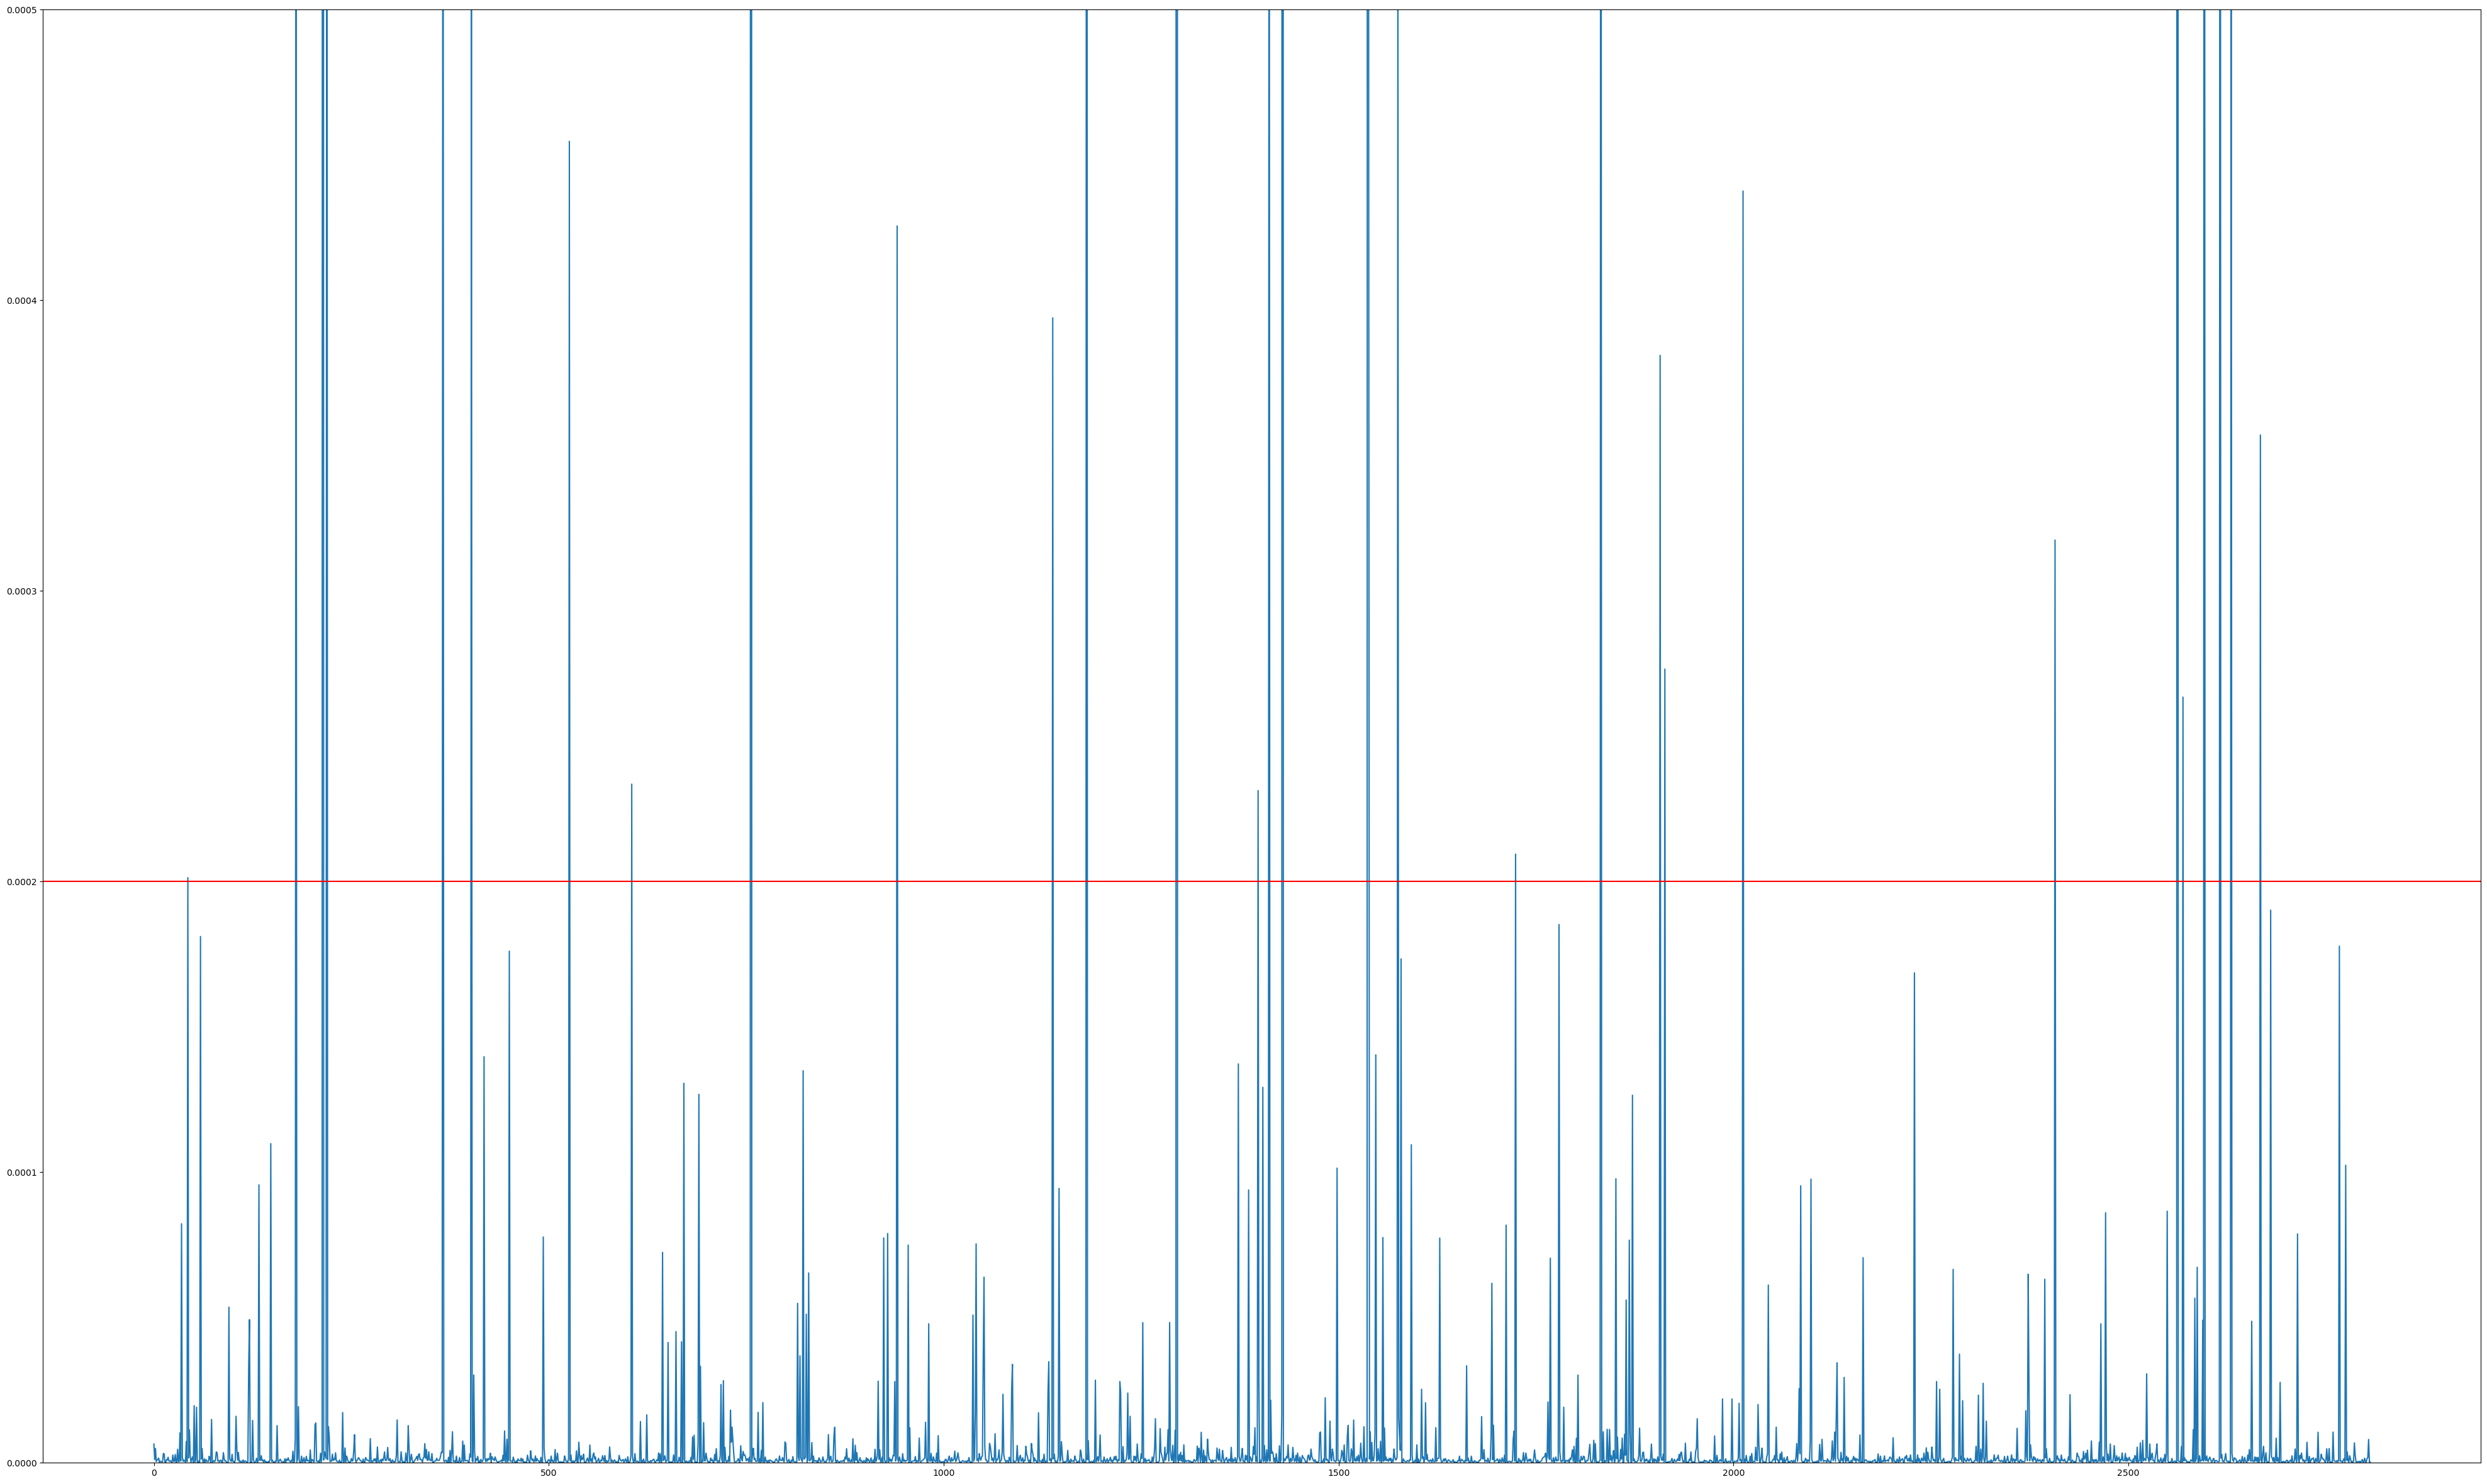

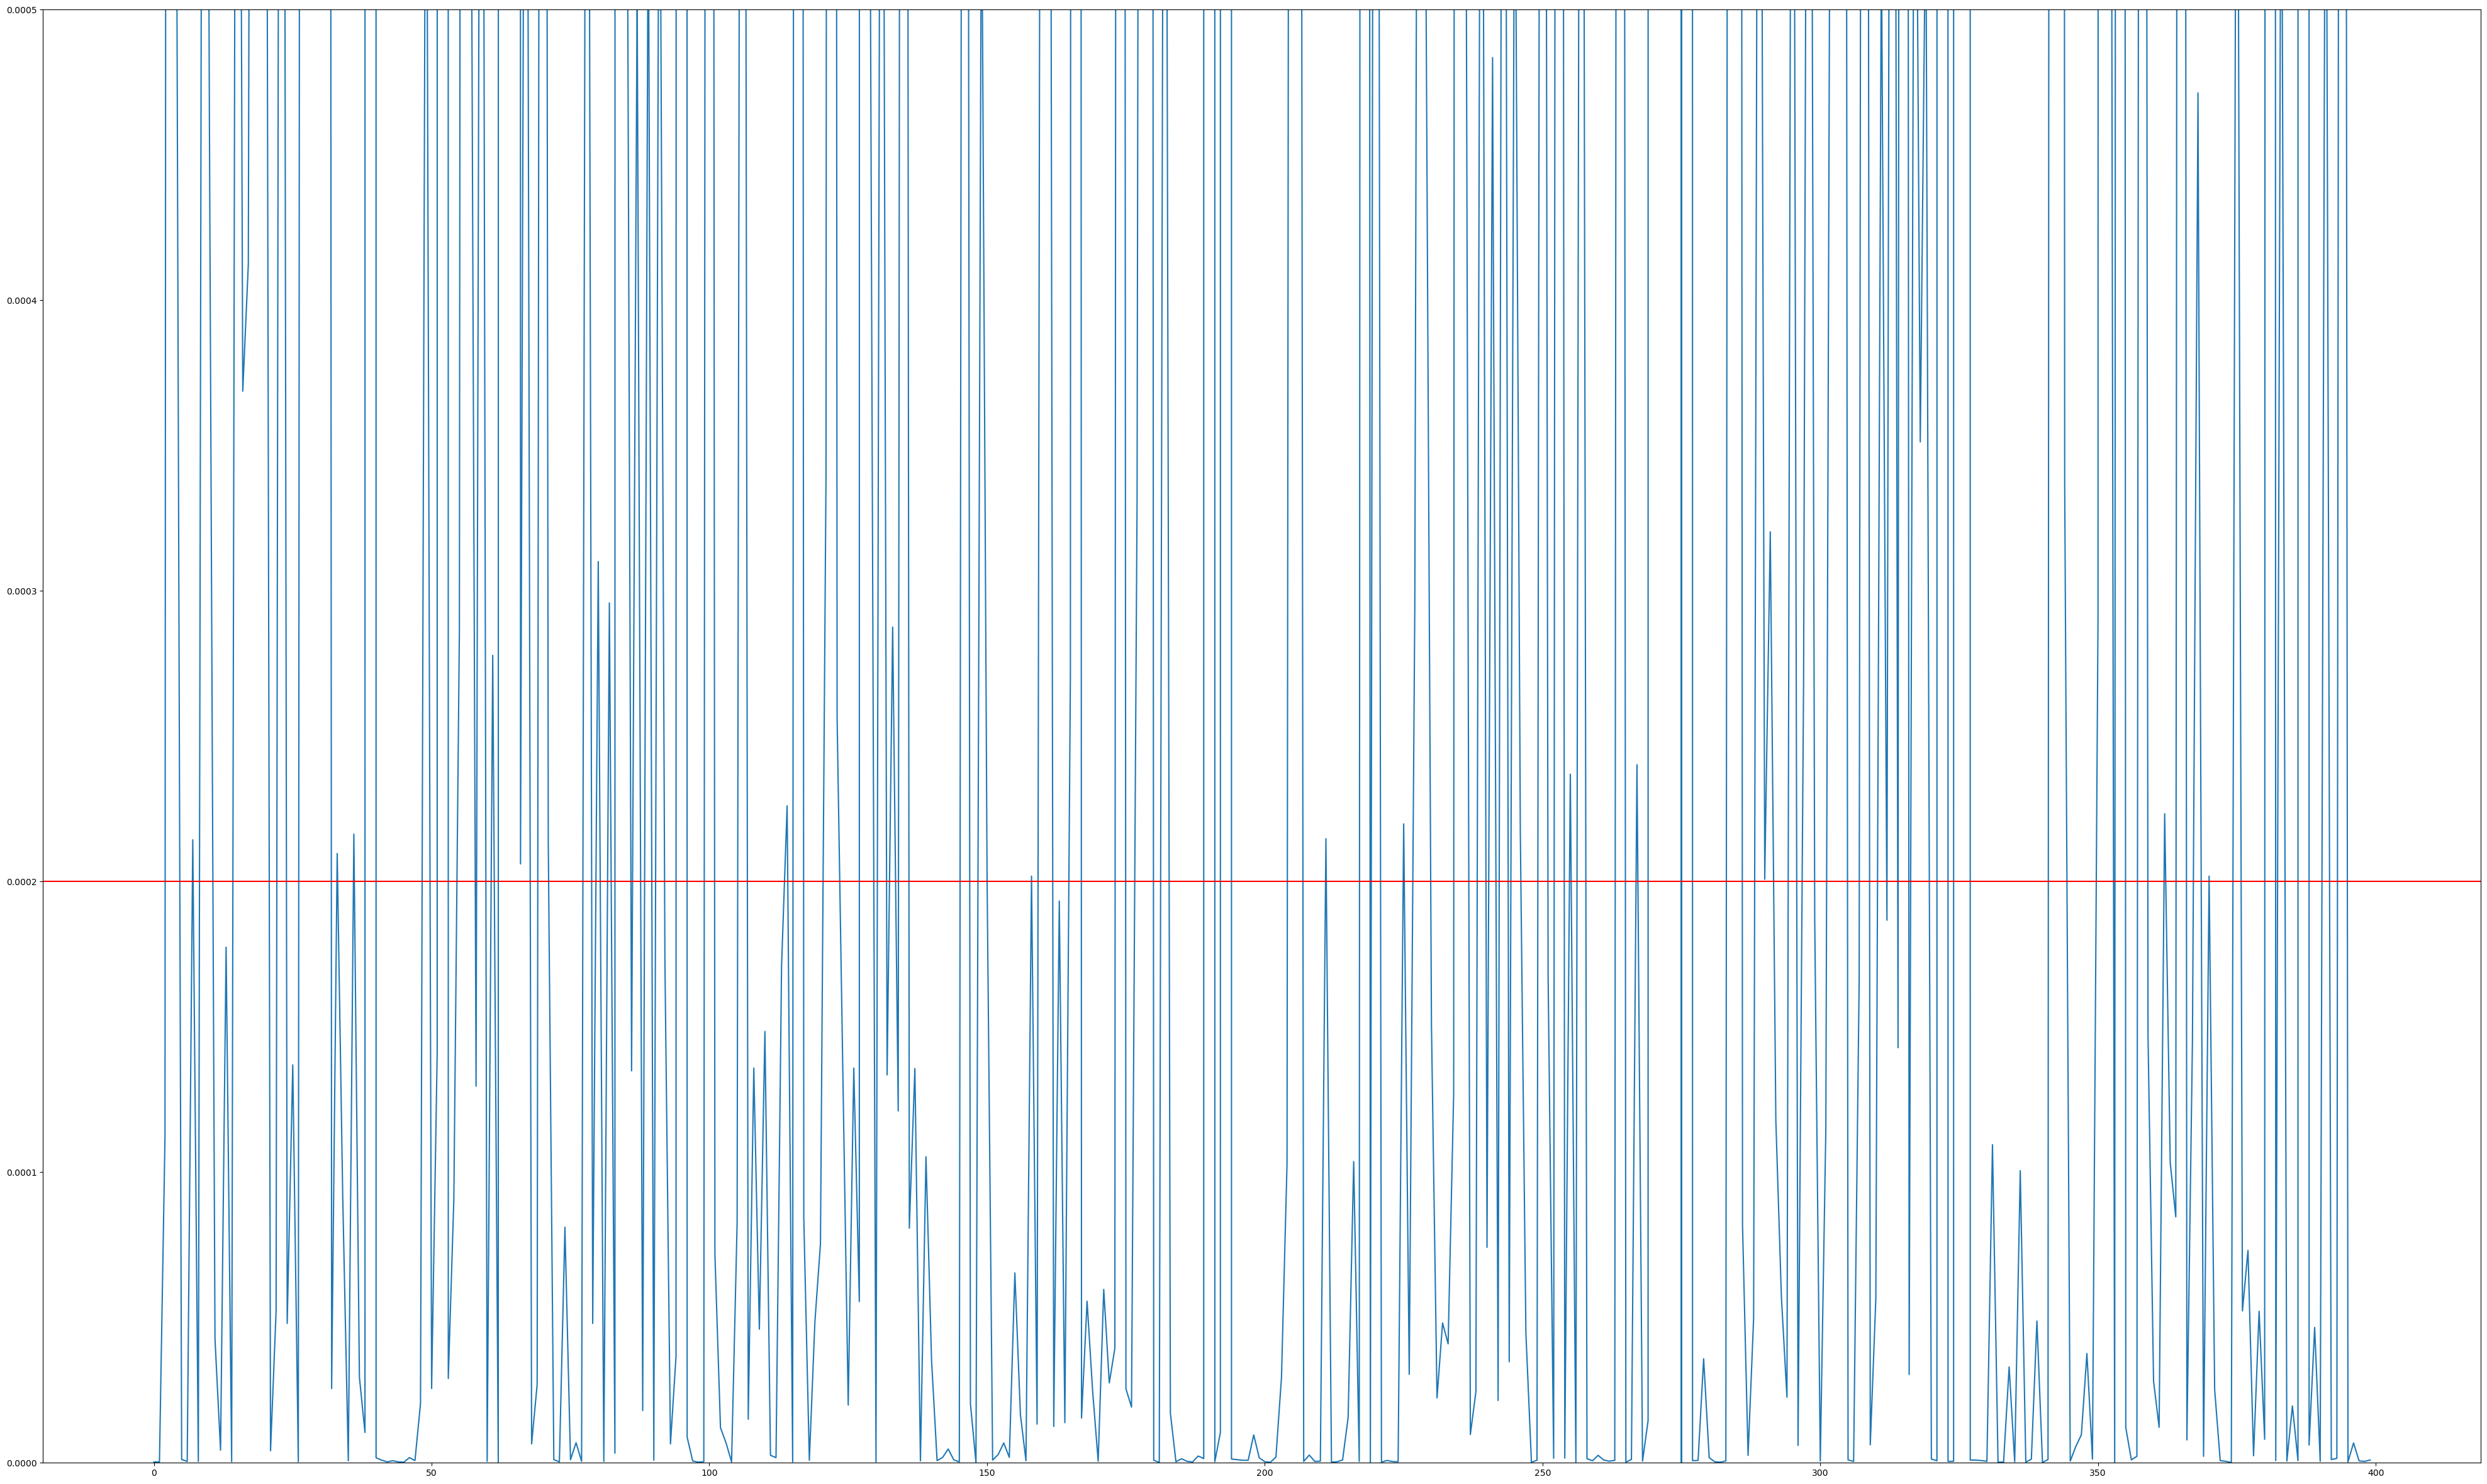

In [94]:
plt.figure(figsize=(50,30))
plt.plot(mse_list_normal)
plt.axhline(best_thr, color='r')
plt.ylim([0,0.0005])
plt.show()
plt.figure(figsize=(50,30))
plt.plot(mse_list_val_anomaly)
plt.ylim([0,0.0005])
plt.axhline(best_thr, color='r')
plt.show()


Confusion matrix
[2671 136]
[52 71]
Detect Anomaly in Test Data : 71 / Whole Test Data 123 
F1 : 0.43030
Precision : 0.34300
Recall : 0.57724
Sensitivity : 0.95155
False-Positive Rate : 0.04845


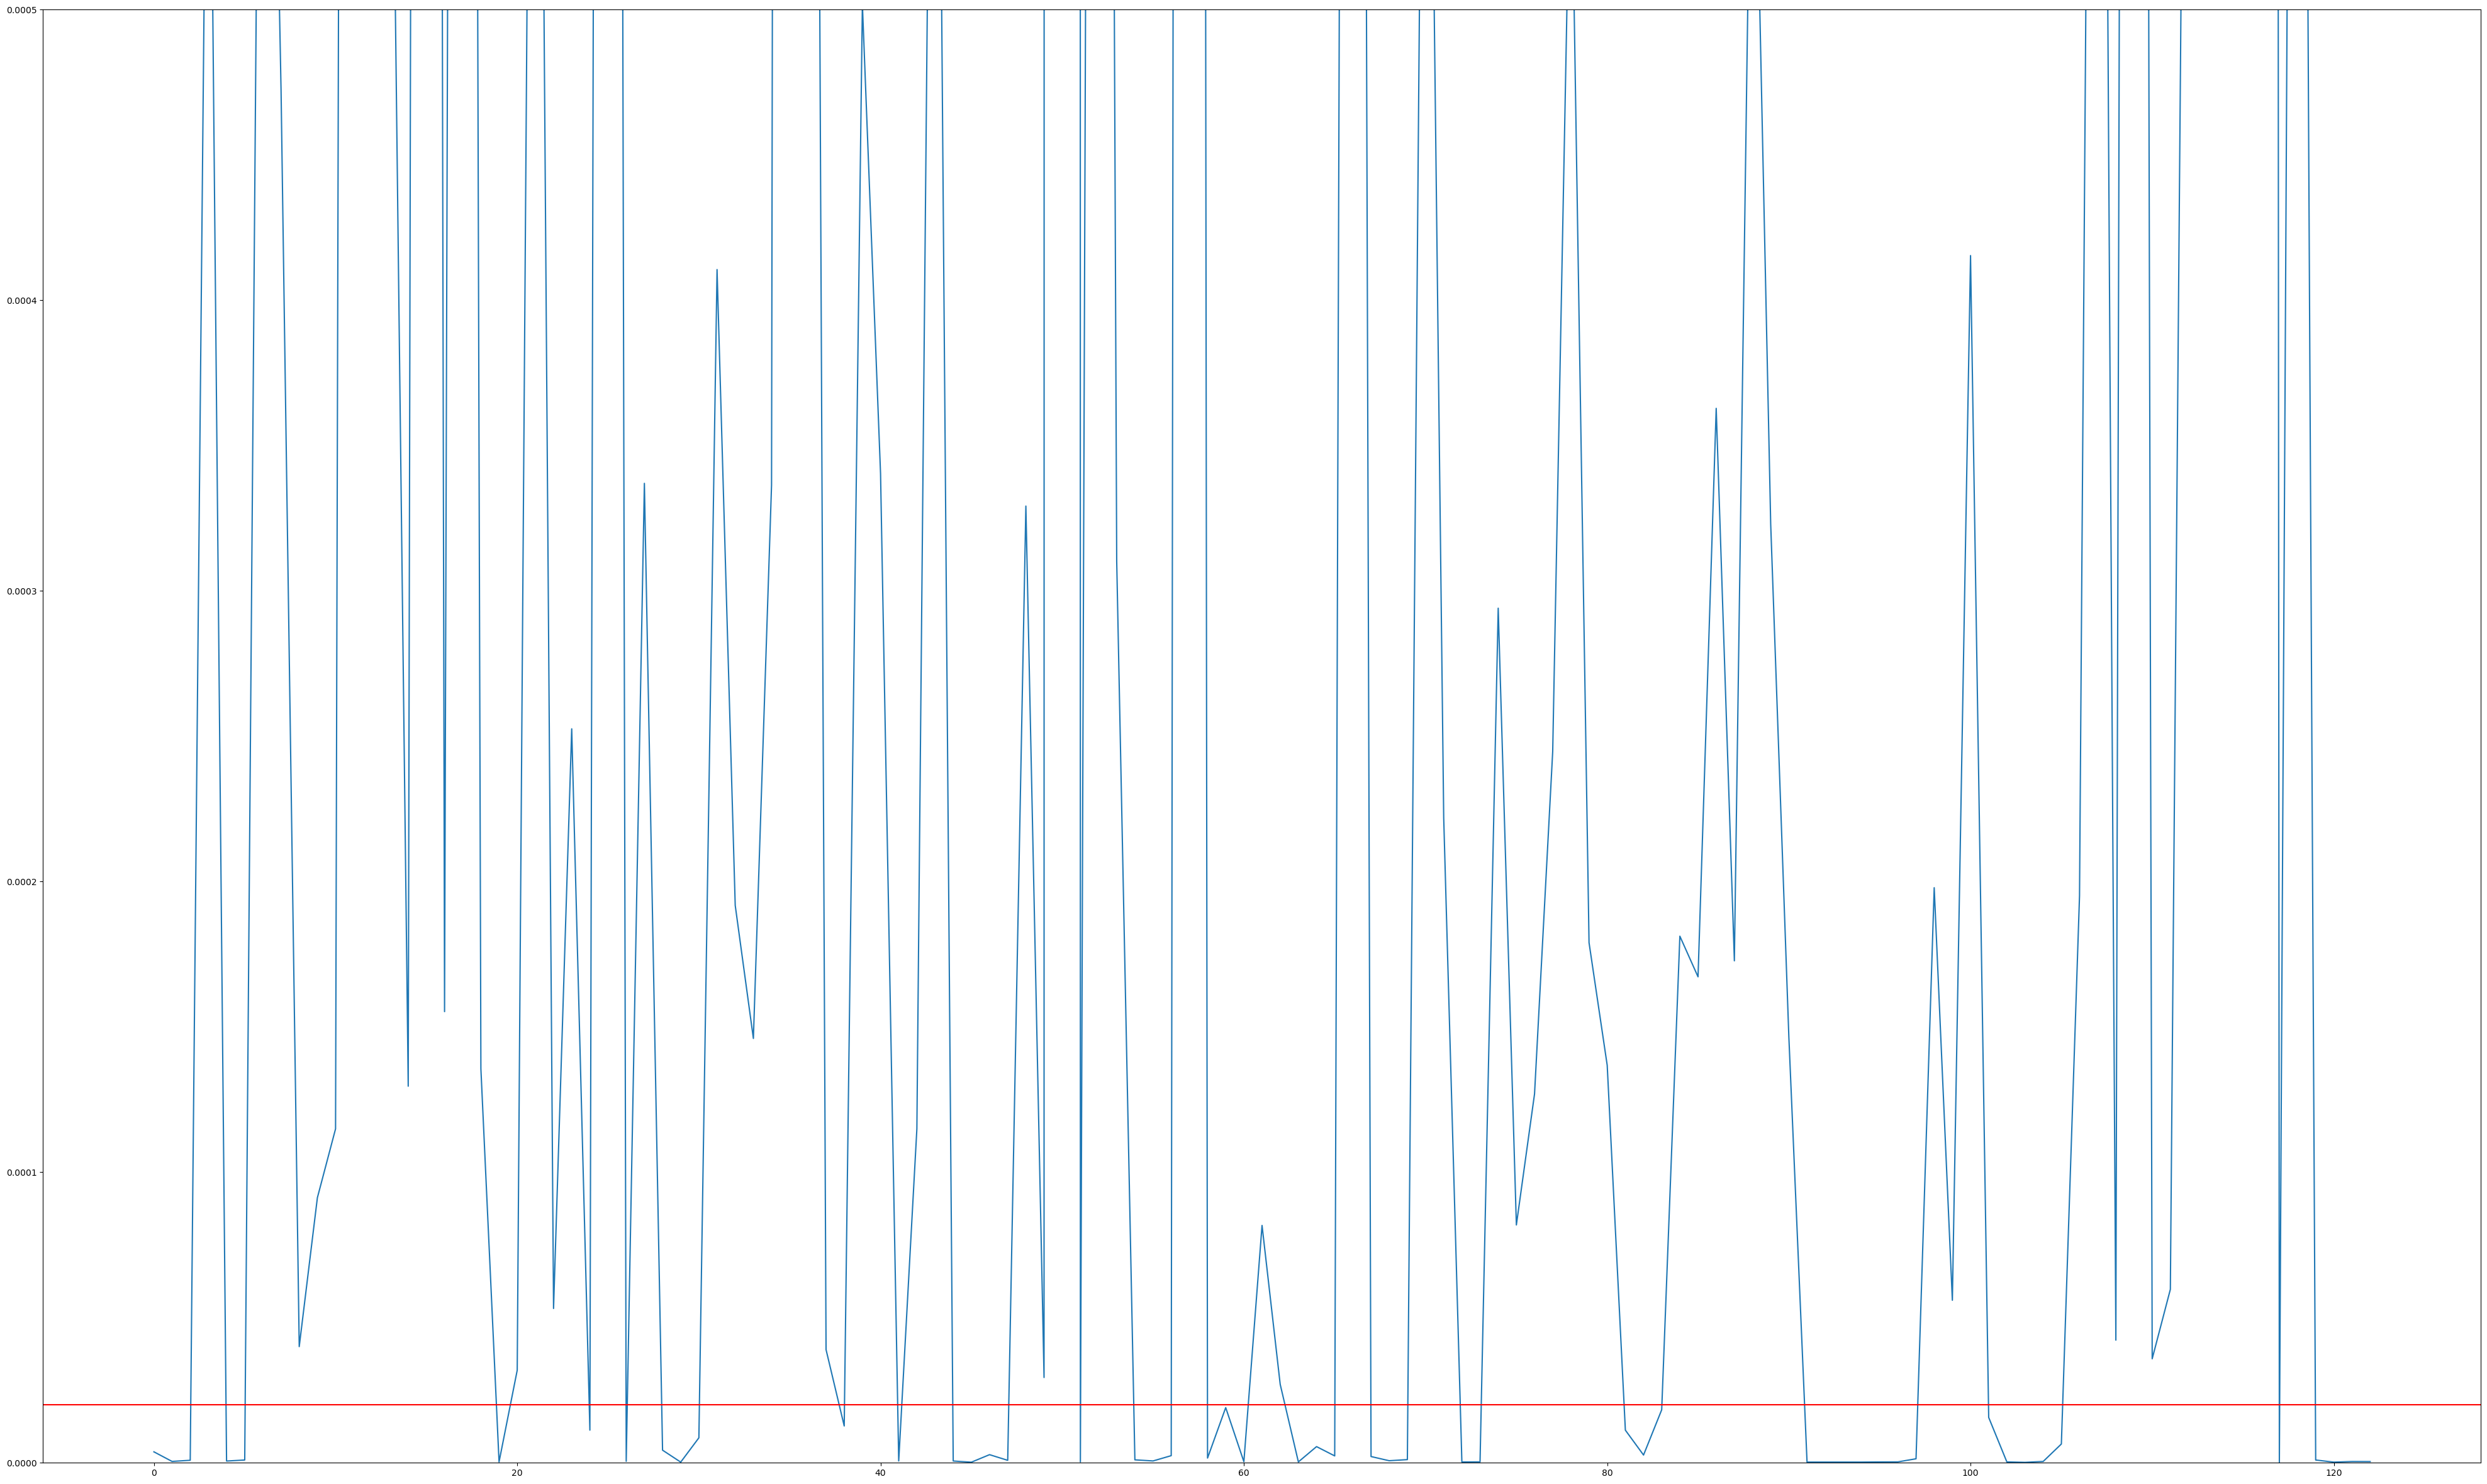

In [98]:
test_anomaly_count = 0
test_normal_count = 0
test_false_positive = 0
for i in range(len(mse_list_test_anomaly)):
    if mse_list_test_anomaly[i] > best_thr:
        test_anomaly_count = test_anomaly_count+1
for i in range(len(mse_list_test_normal)):
    if mse_list_test_normal[i] > best_thr:
        test_false_positive = test_false_positive + 1
        
precision = test_anomaly_count / (test_anomaly_count + test_false_positive)
recall = test_anomaly_count / len(mse_list_test_anomaly)
f1_score = 2 * precision * recall/(precision+recall)
        
print("Confusion matrix")
print(f"[{len(mse_list_test_normal)-test_false_positive} {test_false_positive}]\n[{len(mse_list_test_anomaly)-test_anomaly_count} {test_anomaly_count}]")
print(f"Detect Anomaly in Test Data : {str(test_anomaly_count)} / Whole Test Data {str(len(mse_list_test_anomaly))} ")
print(f"F1 : {f1_score:.5f}")
print(f"Precision : {precision:.5f}")
print(f"Recall : {recall:.5f}")
print(f"Sensitivity : {1-test_false_positive/len(mse_list_test_normal):.5f}")
print(f"False-Positive Rate : {test_false_positive/len(mse_list_test_normal):.5f}")
plt.figure(figsize=(50,30))
plt.plot(mse_list_test_anomaly)
plt.ylim([0,0.0005])
plt.axhline(best_thr, color='r')
plt.show()